# Import Libraries

In [0]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Bidirectional, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras import backend as K
from keras import regularizers
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Check for GPU

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load Data

Download Data from Google Drive

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1l6EHtc6hy2VrwLZGX0APpV09L11y2B4q' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

    100% |████████████████████████████████| 993kB 19.1MB/s 
title: @NQ_Daily.txt, id: 1lNJ2Axp0utKI8d0lvWpKAaRptqjX5WNq
downloading to /root/data/@NQ_Daily.txt


In [0]:
def load_data(data, seq_len, all_data):
    sequence_length = seq_len + 1
    result = []
    
    # Turn dataset into time-series
    for index in range(len(data) - sequence_length + 1):
        result.append(data[index: index + sequence_length, :])
    
    result = np.array(result)
    # Pre-standardized Data
    original_data = result.copy()
    
    # Standardize Data
    result, scalars = standardize_windows(result)
    result = np.array(result)
    
    # Split into Training and Test Sets
    row = round(0.8 * result.shape[0])
    train_result = shuffle(result[:int(row),:,:])
    x_train = train_result[:, :-1, :]
    y_train = train_result[:, -1, 3]
    x_test = result[int(row):, :-1, :]
    y_test = result[int(row):, -1, 3]
    original_data = original_data[int(row):, -1, 3]
    dates = all_data['Date'].values[int(row)+seq_len:]
    
    return [x_train, y_train, x_test, y_test, scalars, original_data, dates]

## Standaradize Data

In [0]:
def standardize_windows(window_data):
    standardized_data = []
    scalar = []
    i = 0
    for window in window_data:
        scalar.append(StandardScaler())
        scalar[i].fit(window[:-1])
        standardized_window = scalar[i].transform(window)
        standardized_data.append(standardized_window)
        i += 1
    return standardized_data, scalar

# Helper Functions



## Bidirectional LSTM Autoencoders

In [0]:
def autoencoder(data):
  
  input_data = tf.keras.Input(shape=(data.shape[1], data.shape[2]))
  
  x = Bidirectional(LSTM(512, return_sequences=True))(input_data)
  
  encoded = Bidirectional(LSTM(256))(x)
  
  x = RepeatVector(data.shape[1])(encoded)
  
  x = Bidirectional(LSTM(256, return_sequences=True))(x)
  
  x = Bidirectional(LSTM(512, return_sequences=True))(x)
  
  x = TimeDistributed(Dense(16))(x)
  
  model = tf.keras.Model(input_data, x)

  opt = tf.train.AdamOptimizer()

  model.compile(loss='mse', optimizer=opt)
  
  model.summary()
  
  callbacks_list = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  ]

  history = model.fit(data,
                      data,
                      batch_size=256,
                      epochs=5000,
                      shuffle=True,
                      callbacks=callbacks_list,
                      validation_split=0.1,
                      verbose=1)
  
  plot_loss(history)
  
  encoder = tf.keras.Model(input_data, encoded)
  
  return model, encoder

## Create Prediction Model

In [0]:
def create_model(data):
  
  input_data = tf.keras.Input(shape=(data.shape[1],))

  x = Dense(512, activation='relu')(input_data)
  
  x = Dense(512, activation='relu')(x)

  x = Dense(1, activation='linear')(x)

  model = tf.keras.Model(input_data, x)

  opt = tf.train.AdamOptimizer()

  model.compile(loss='mse', optimizer=opt)

  model.summary()
  
  return model

## Plot Loss

In [0]:
def plot_loss(history):
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

## Transform Values into Directional Data

In [0]:
def directional_data(data, original_data):
    result = []
    x = 0
    y = 0
    z = 0
    for j in range(1,len(data)):
        i = j
        if abs(data[i]-original_data[i-1]) < (0.3/100*original_data[i-1]):
            result.append([0,1,0])
            x = x+1
        elif data[i] > original_data[i-1]:
            result.append([0,0,1])
            y = y+1
        else:
            result.append([1,0,0])
            z = z+1
    print("No change: " + str(x))
    print("Up: " + str(y))
    print("Down: " + str(z))
    result = np.array(result)
    return result

## Plot Results

In [0]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

## Plot Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ["Down", "No Change", "Up"]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    mpl.rcParams['axes.grid'] = False
    fig, ax = plt.subplots(1,1, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.show
    return ax

# Experiments


## Define Constants and Load Data

In [0]:
epochs  = 100
seq_len = 30

with open(fname, 'r') as f:
  all_data = pd.read_csv(f, sep=',')
df = all_data.drop(["Date","Time", "OpenBar", "FLS"], axis=1)

## First Half

### Load Data

In [0]:
x_train, y_train, x_test, y_test, scalars, original_data, dates = load_data(df.values[:int(len(df)/2)], seq_len, all_data[:int(len(df)/2)])

### Create Bidirectional LSTM Autoencoders

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30, 16)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 30, 1024)          2166784   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               2623488   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 512)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 30, 512)           1574912   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 30, 1024)          4198400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 16)            16400     
Total para

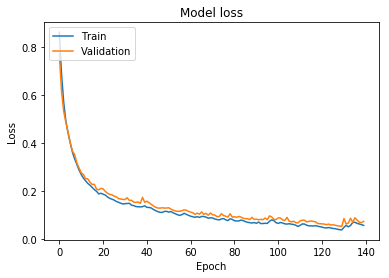

In [0]:
autoencoder_model, encoder = autoencoder(x_train)

In [0]:
autoencoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30, 16)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 30, 1024)          2166784   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               2623488   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 512)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 30, 512)           1574912   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 30, 1024)          4198400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 16)            16400     
Total para

In [0]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30, 16)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 30, 1024)          2166784   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               2623488   
Total params: 4,790,272
Trainable params: 4,790,272
Non-trainable params: 0
_________________________________________________________________


### Reconstruction

#### Training Data

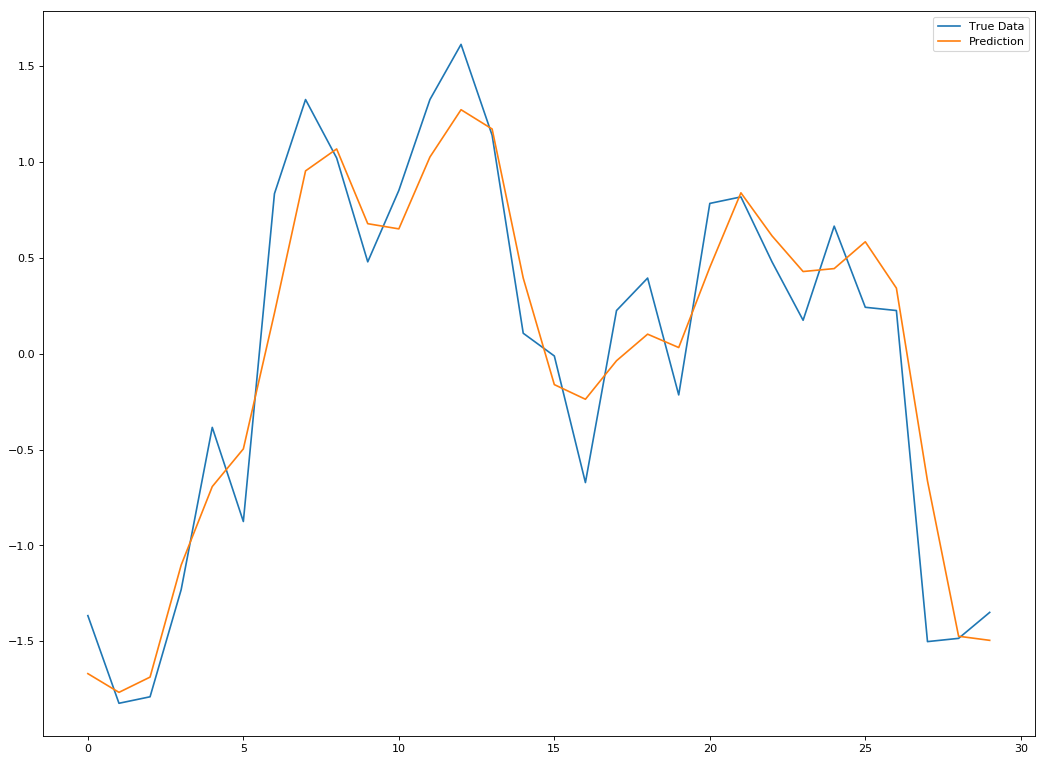

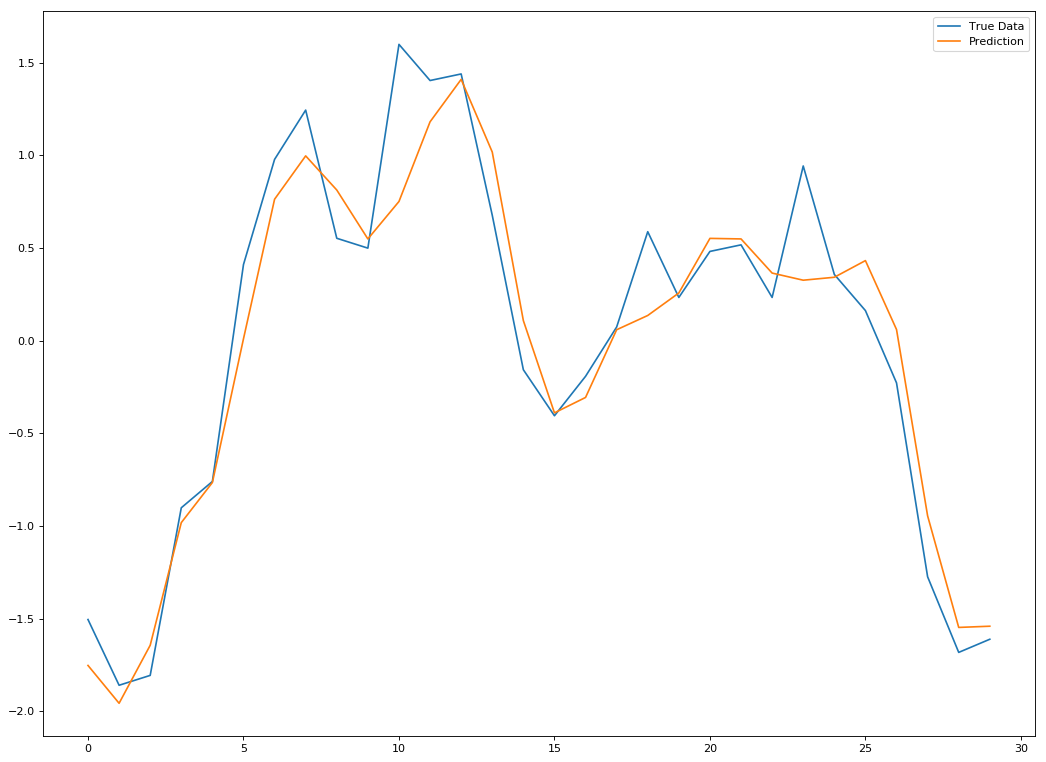

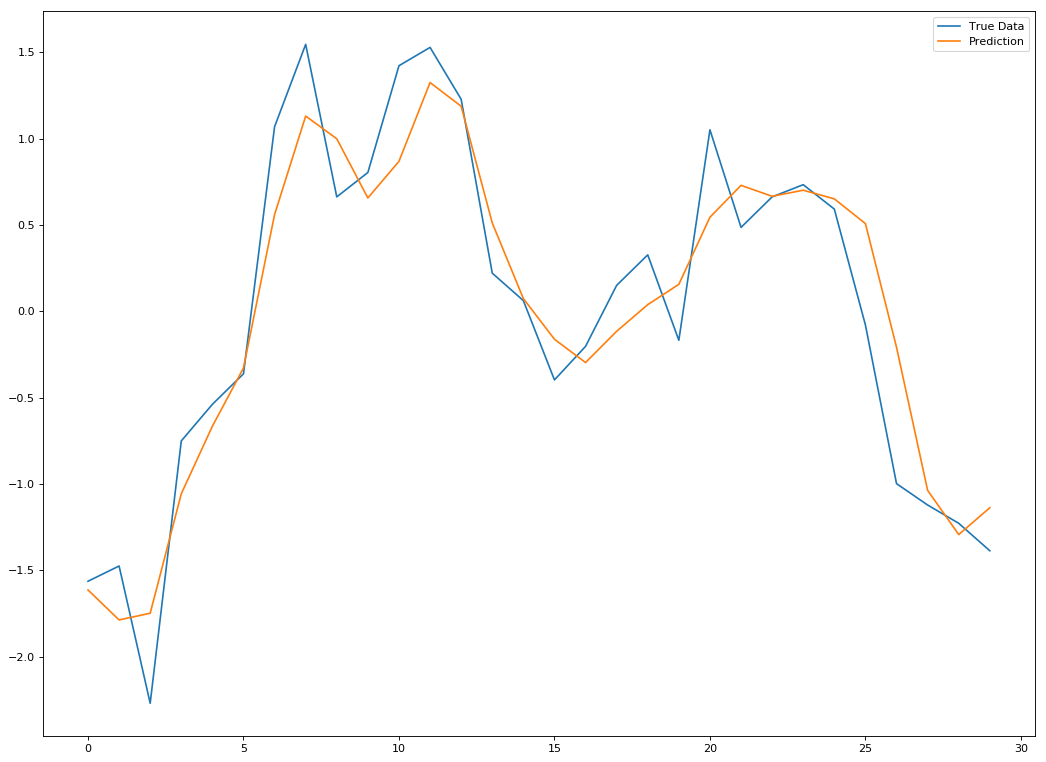

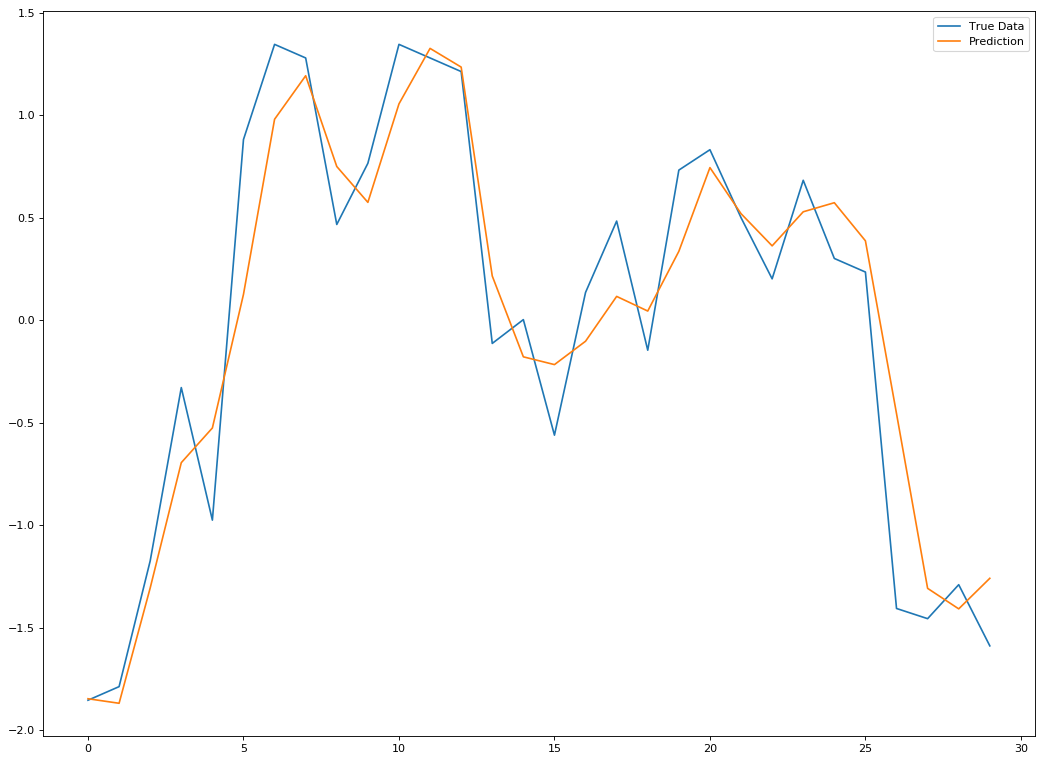

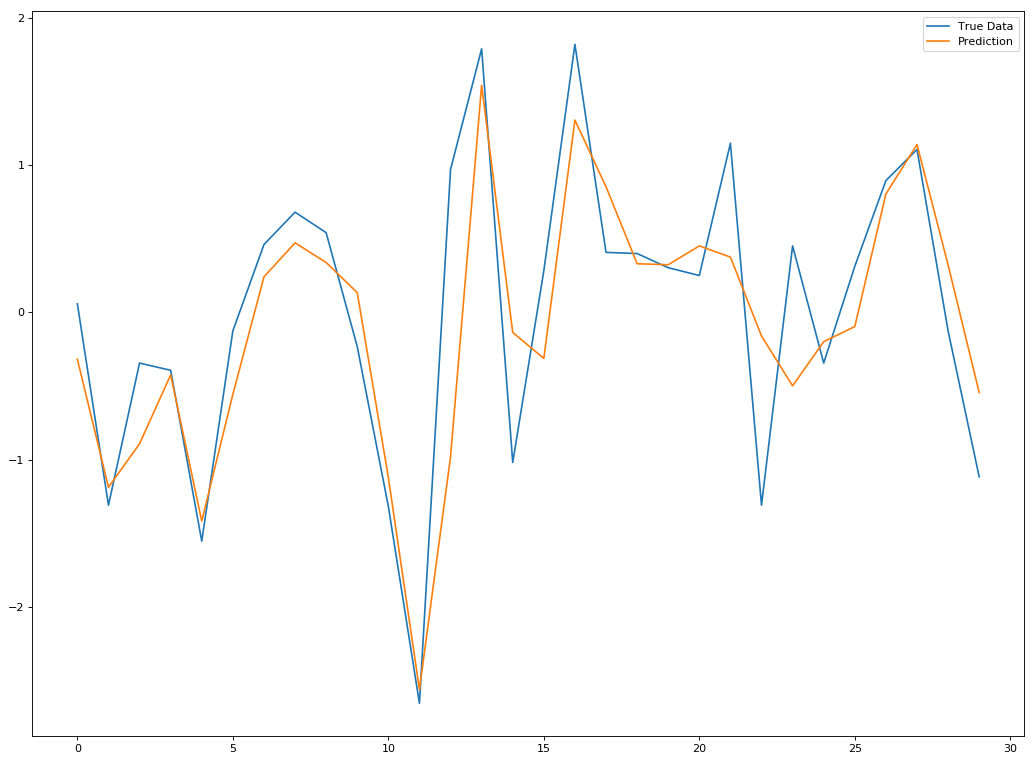

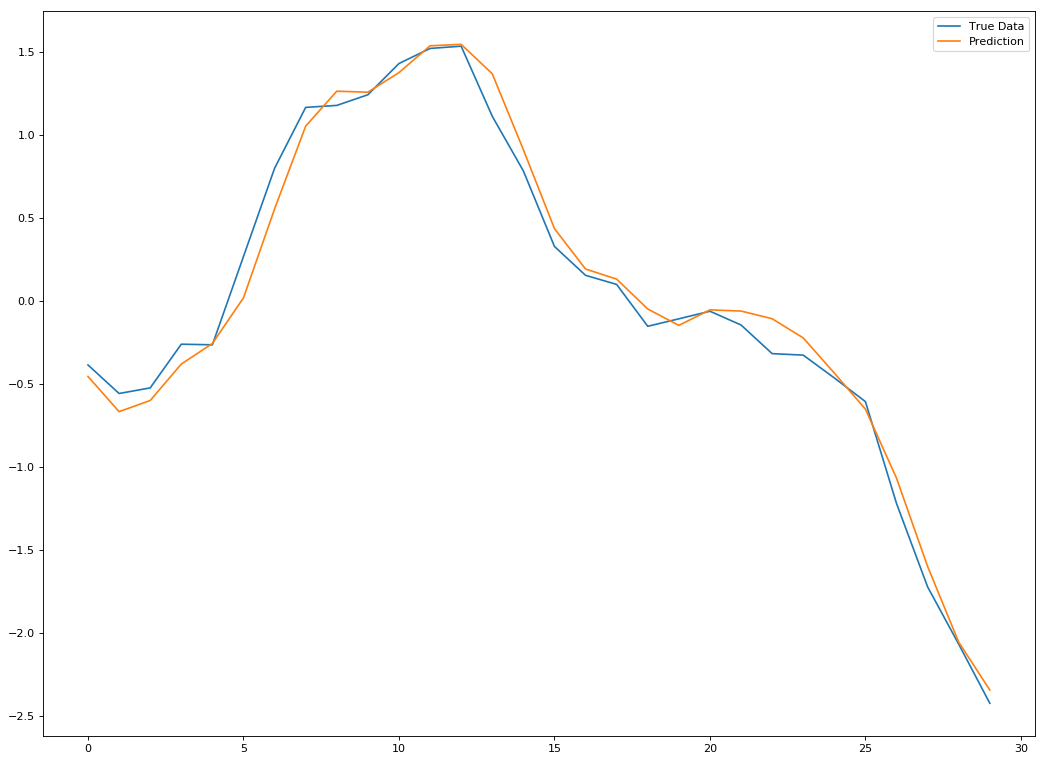

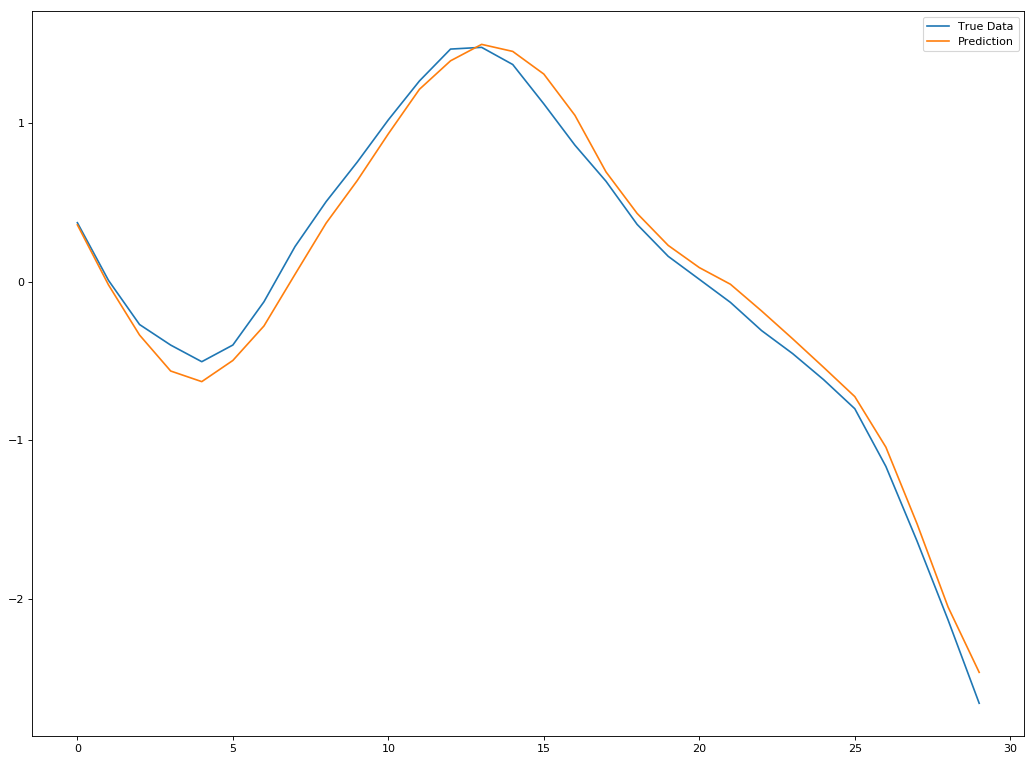

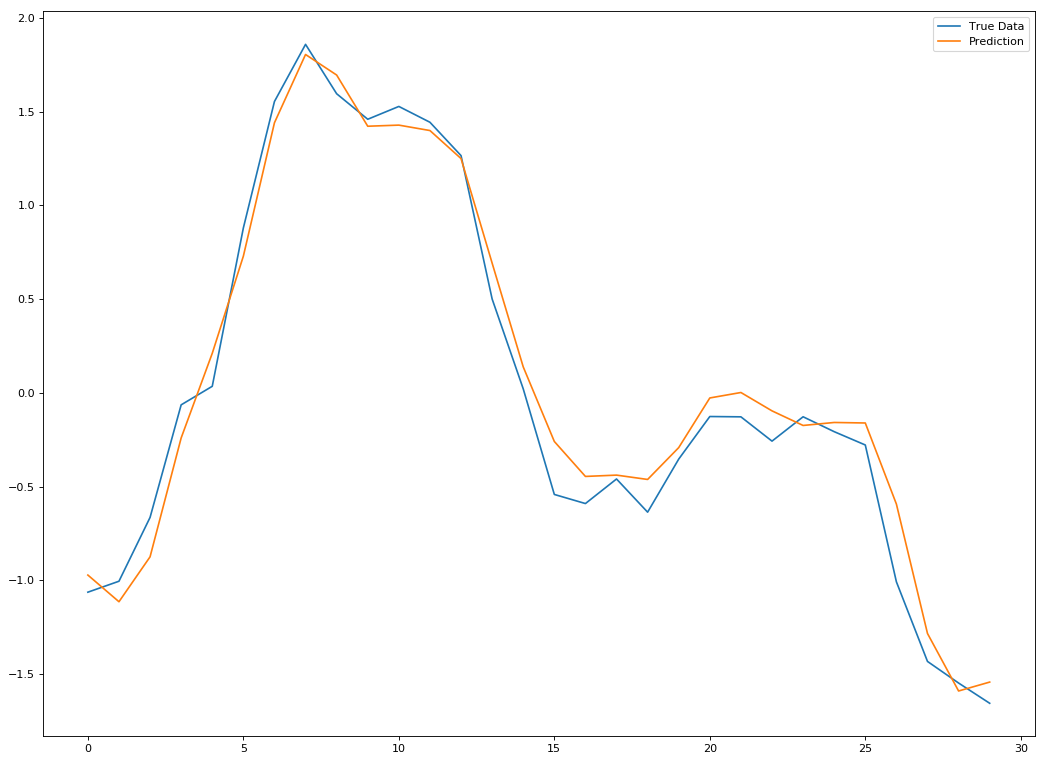

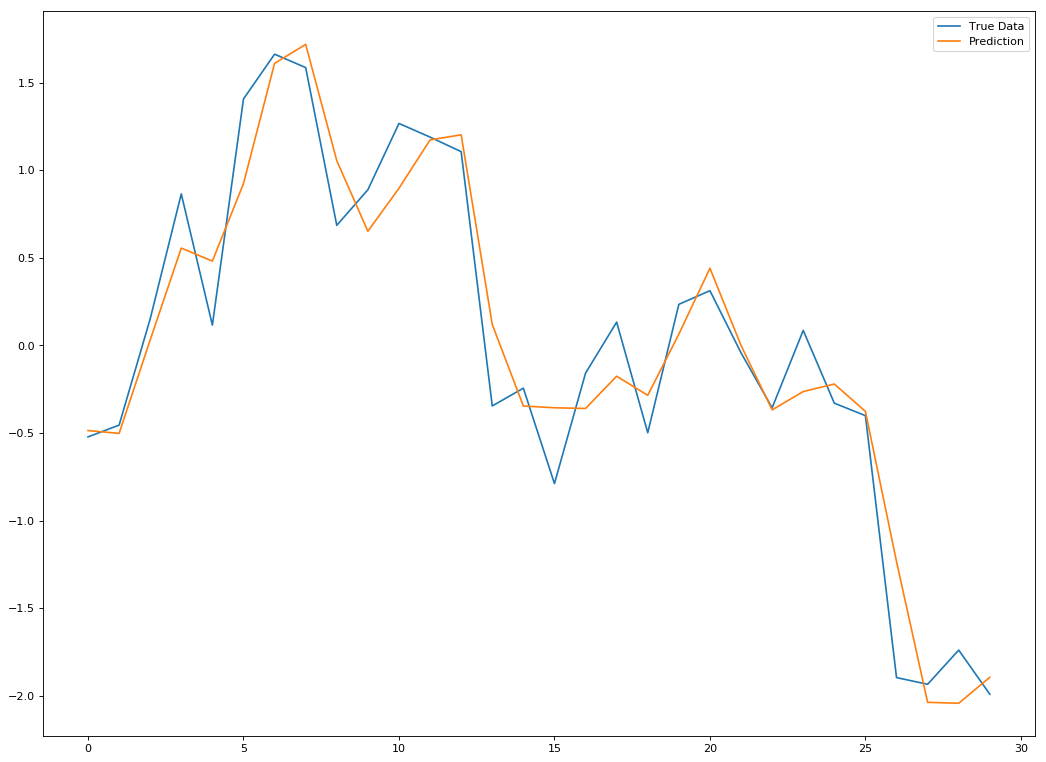

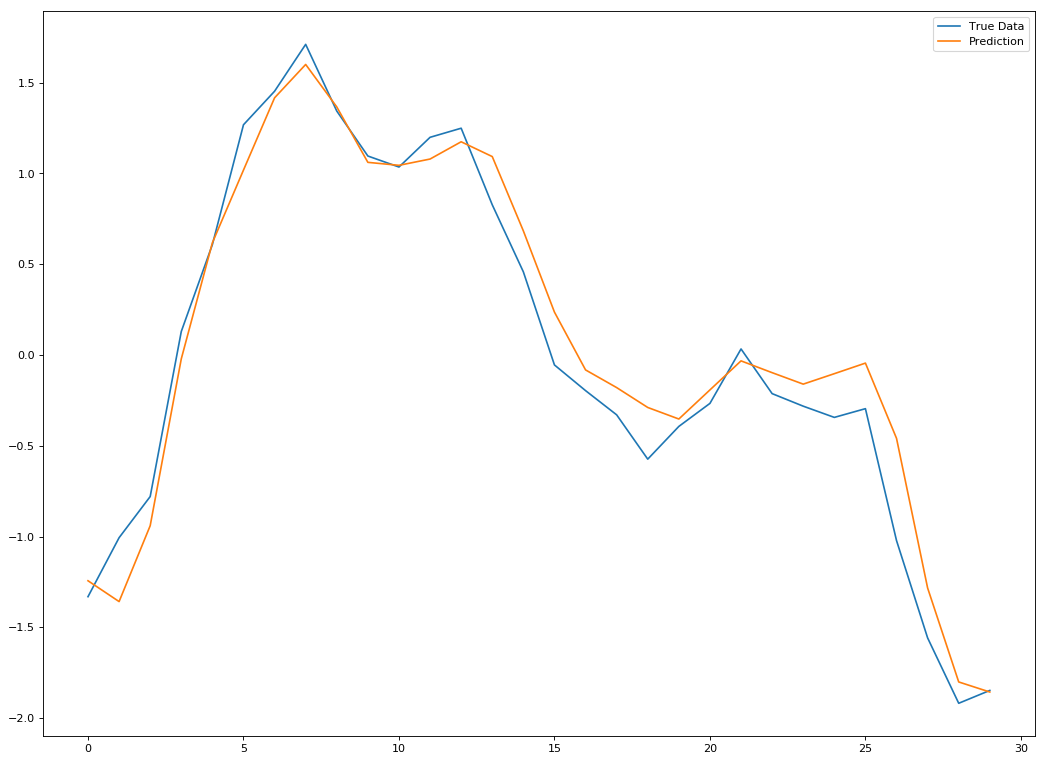

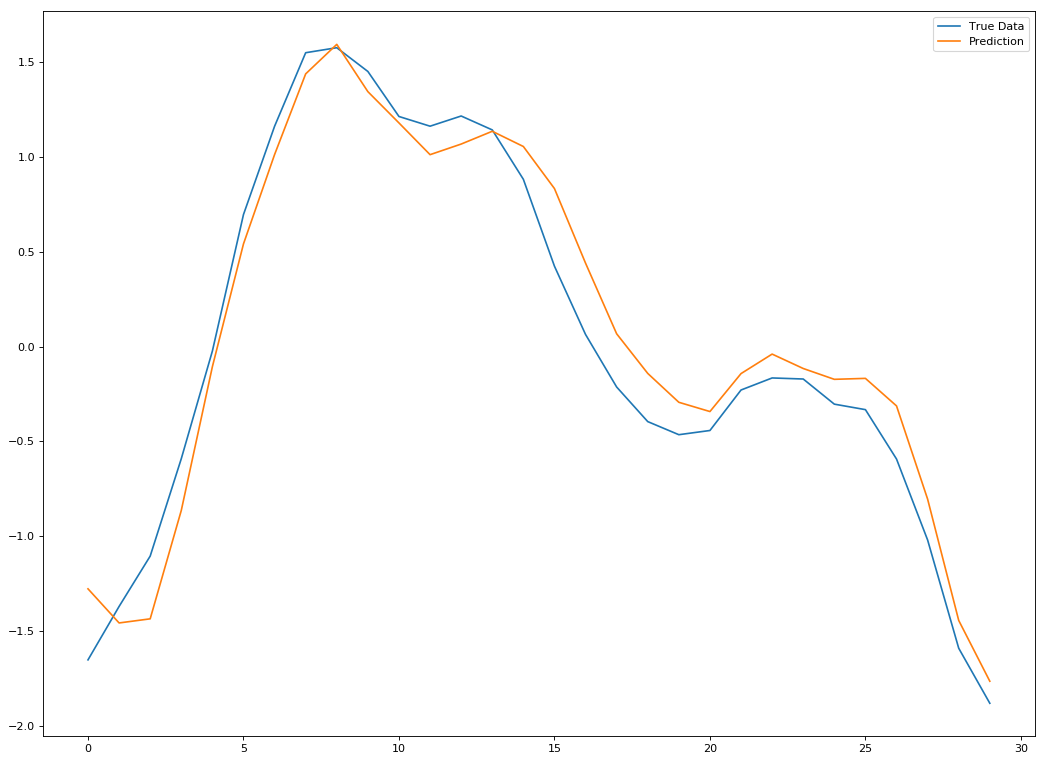

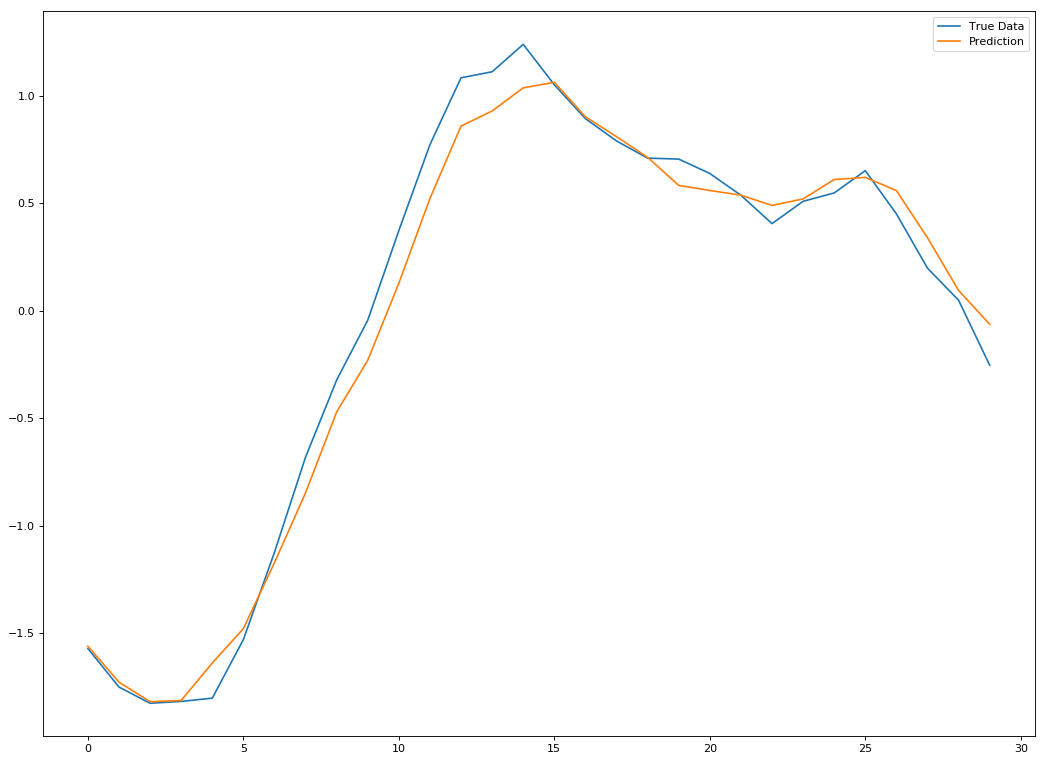

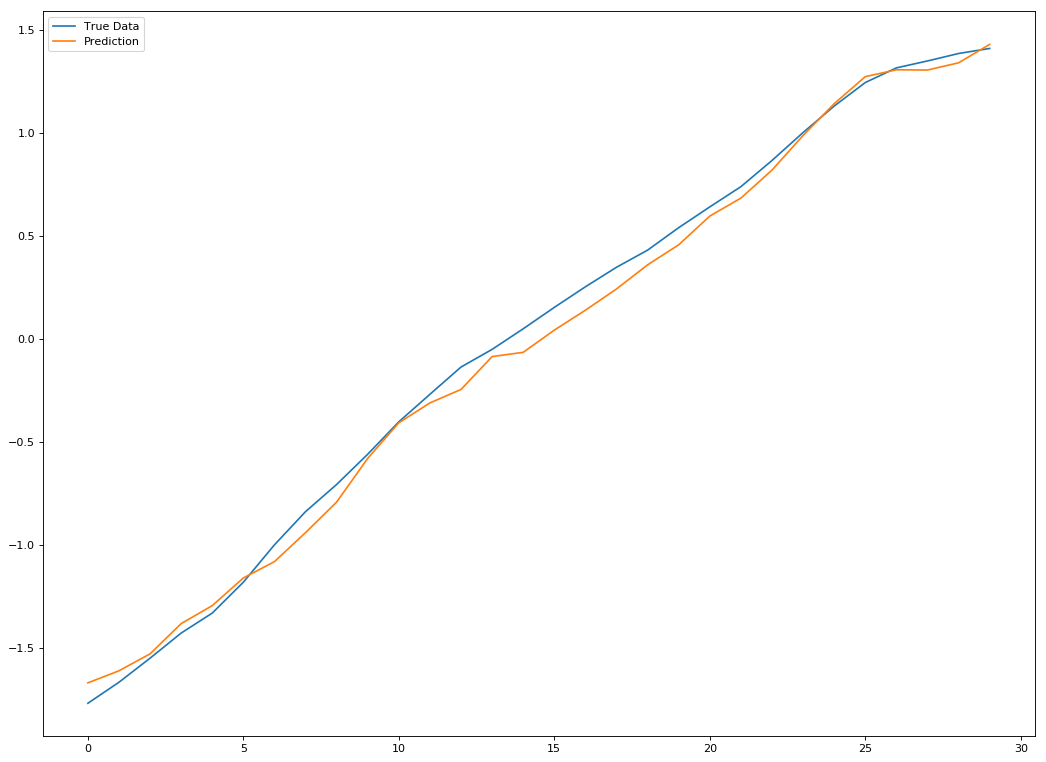

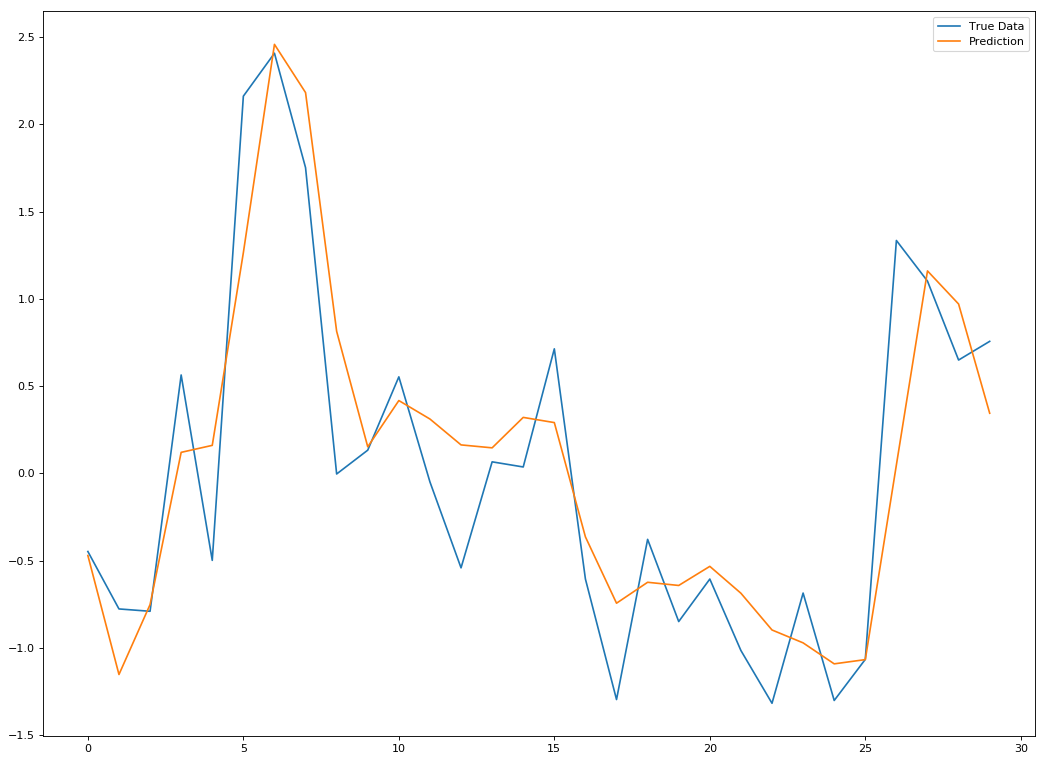

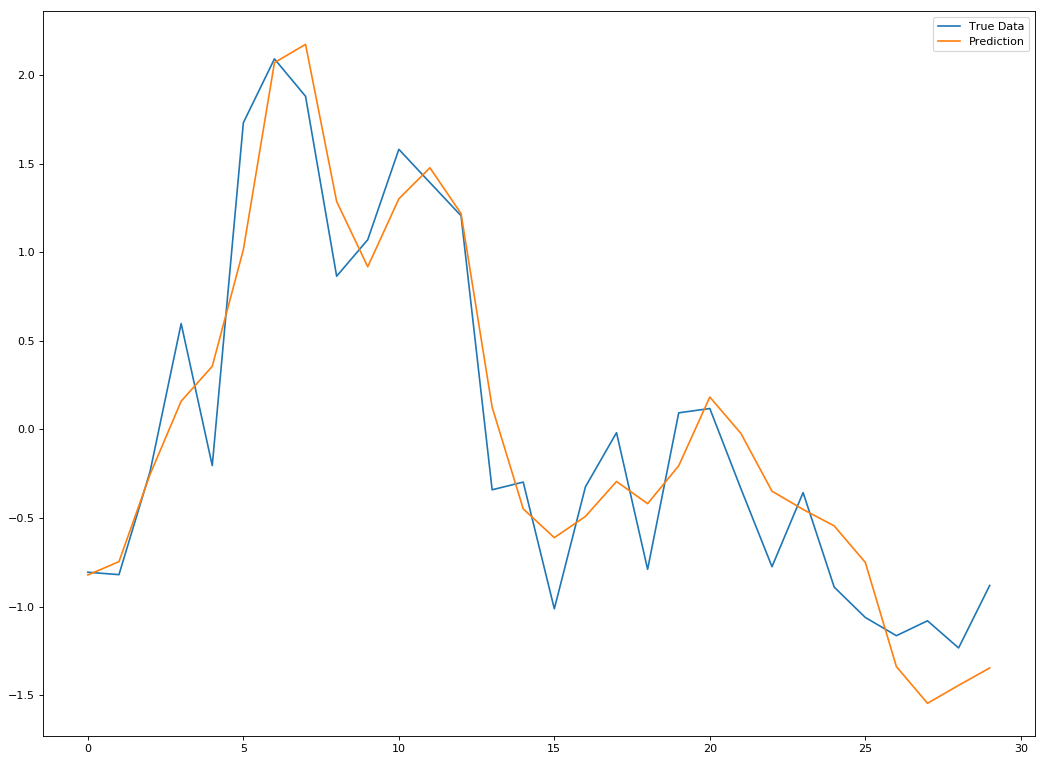

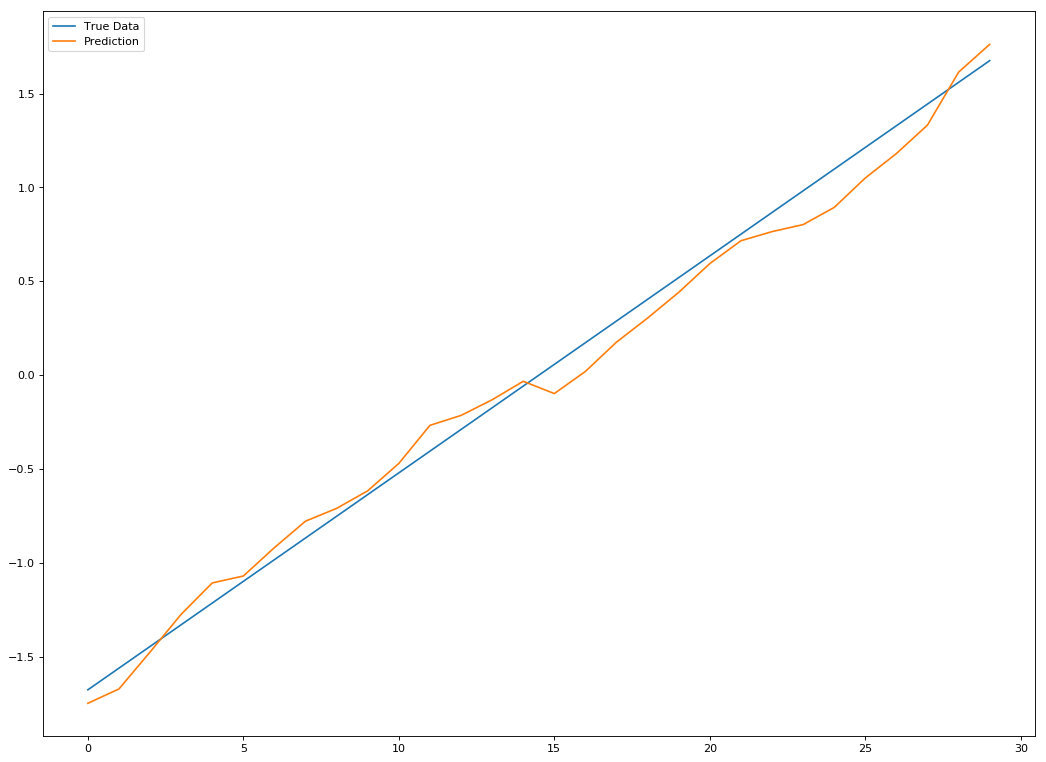

In [0]:
reconstructed_train = autoencoder_model.predict(x_train)

for i in range(x_train.shape[2]):
  plot_results(reconstructed_train[0,:,i], x_train[0,:,i])

#### Testing Data

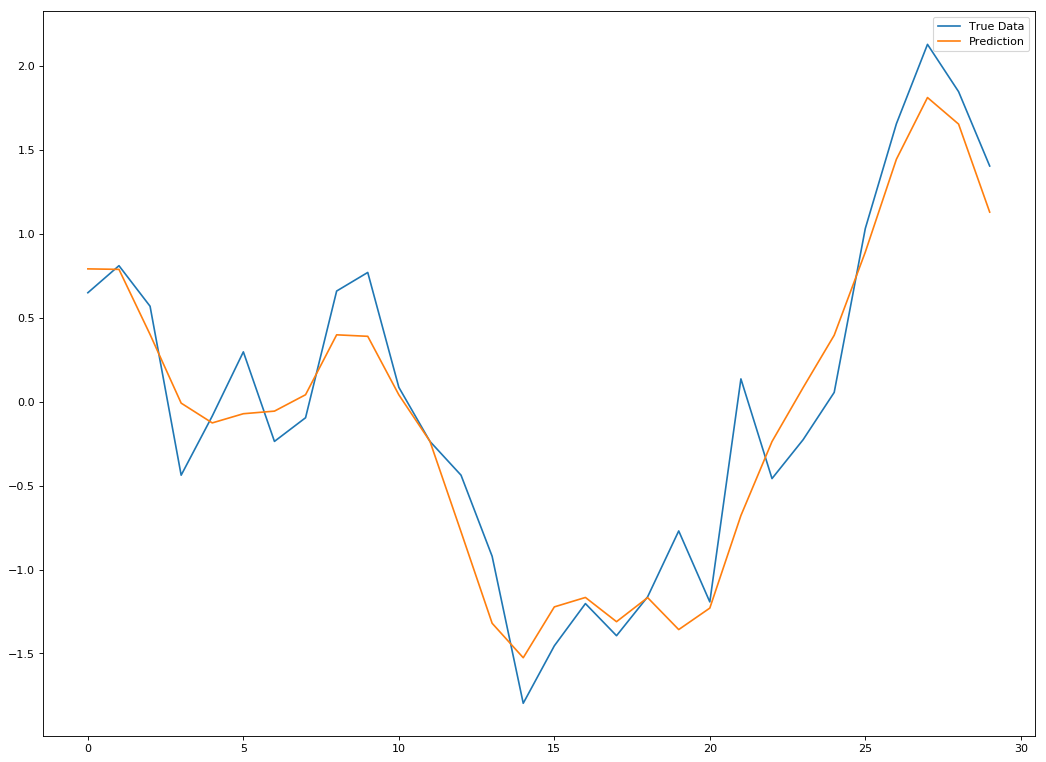

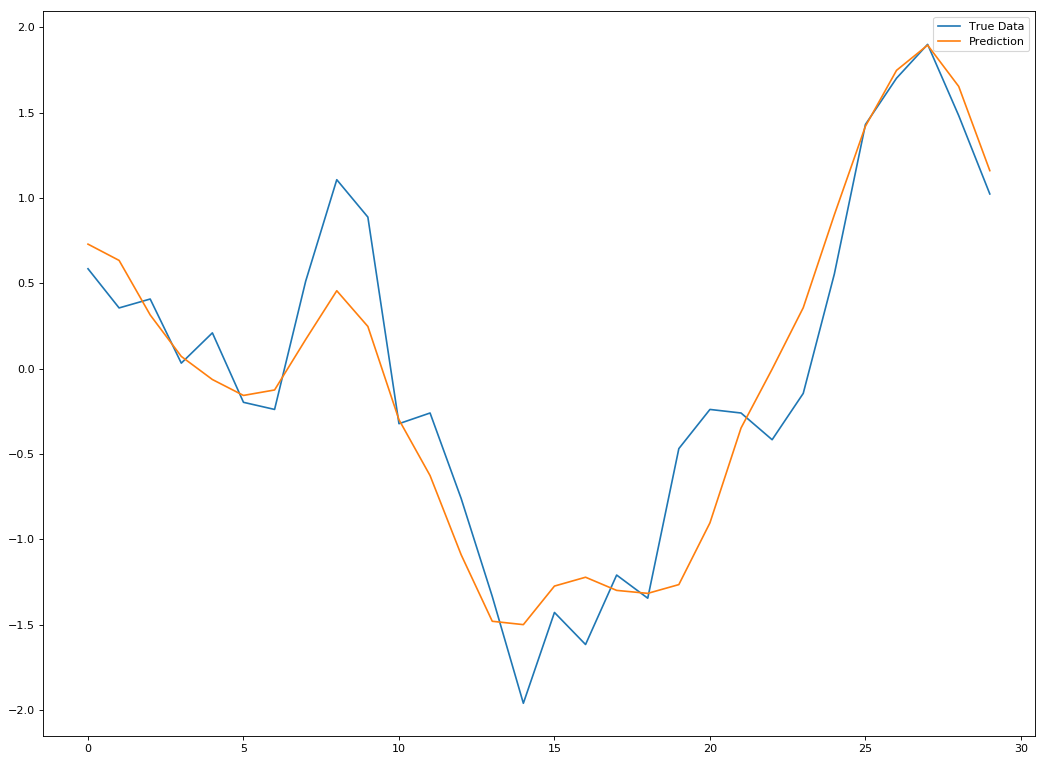

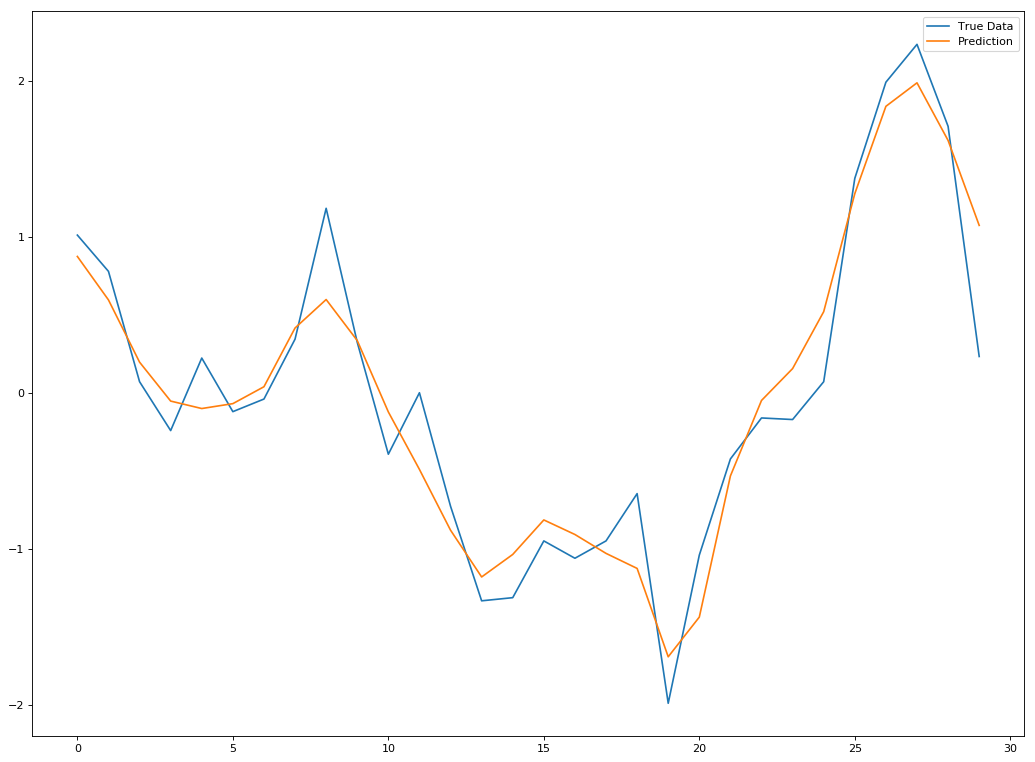

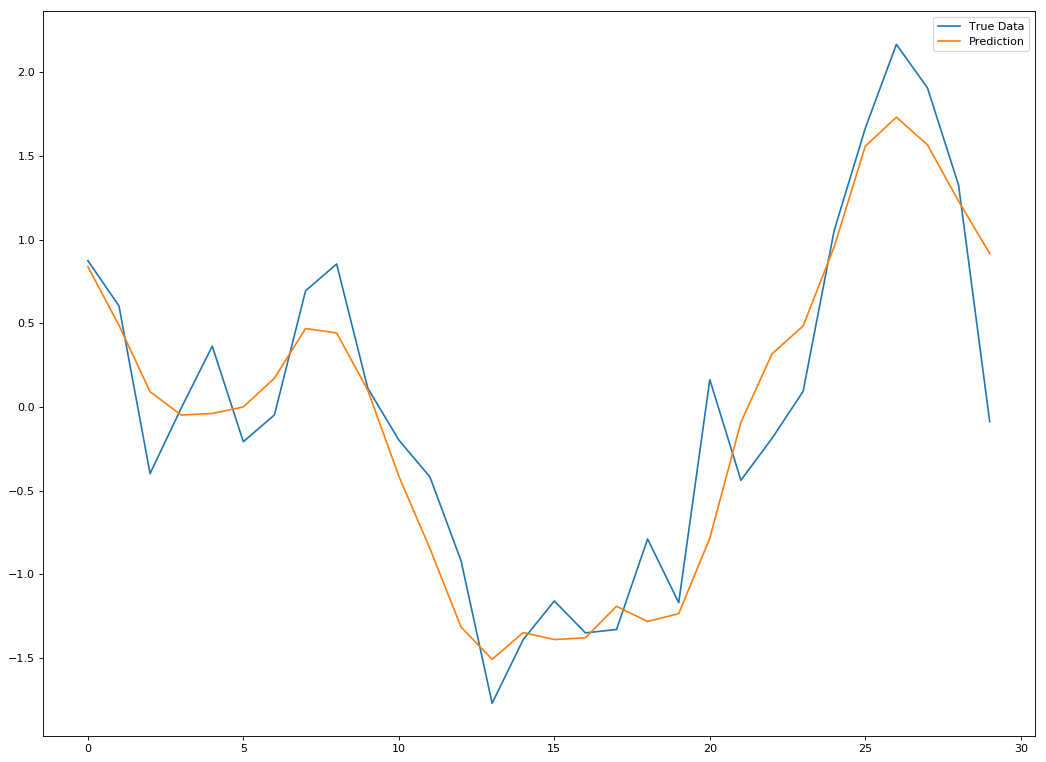

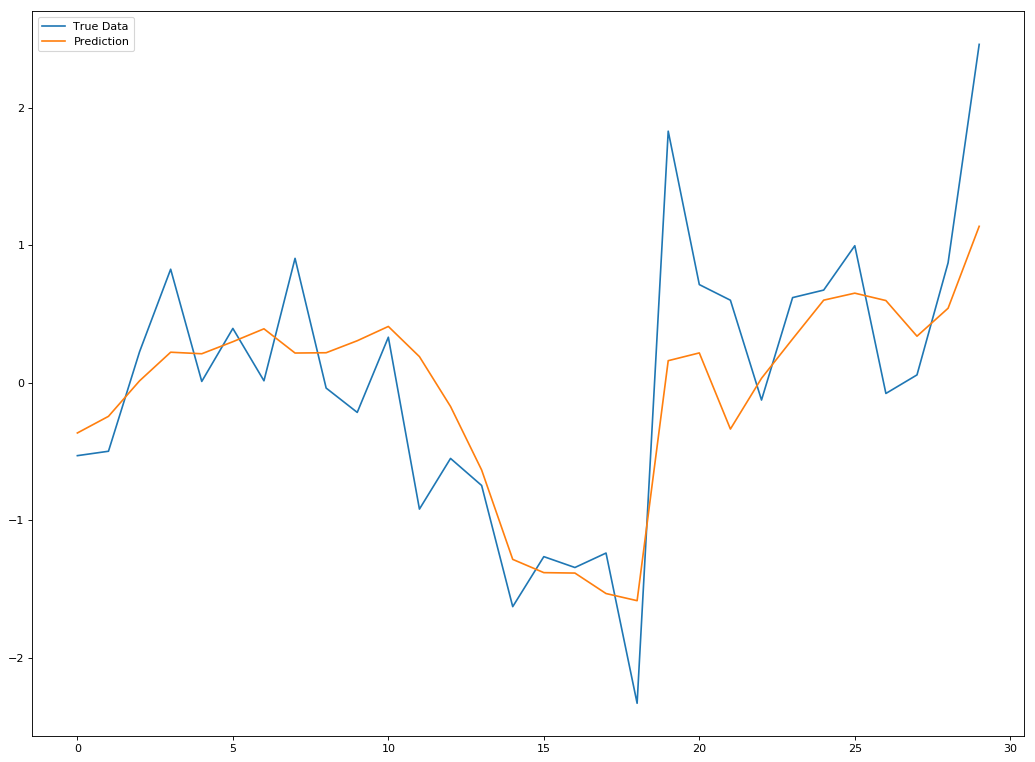

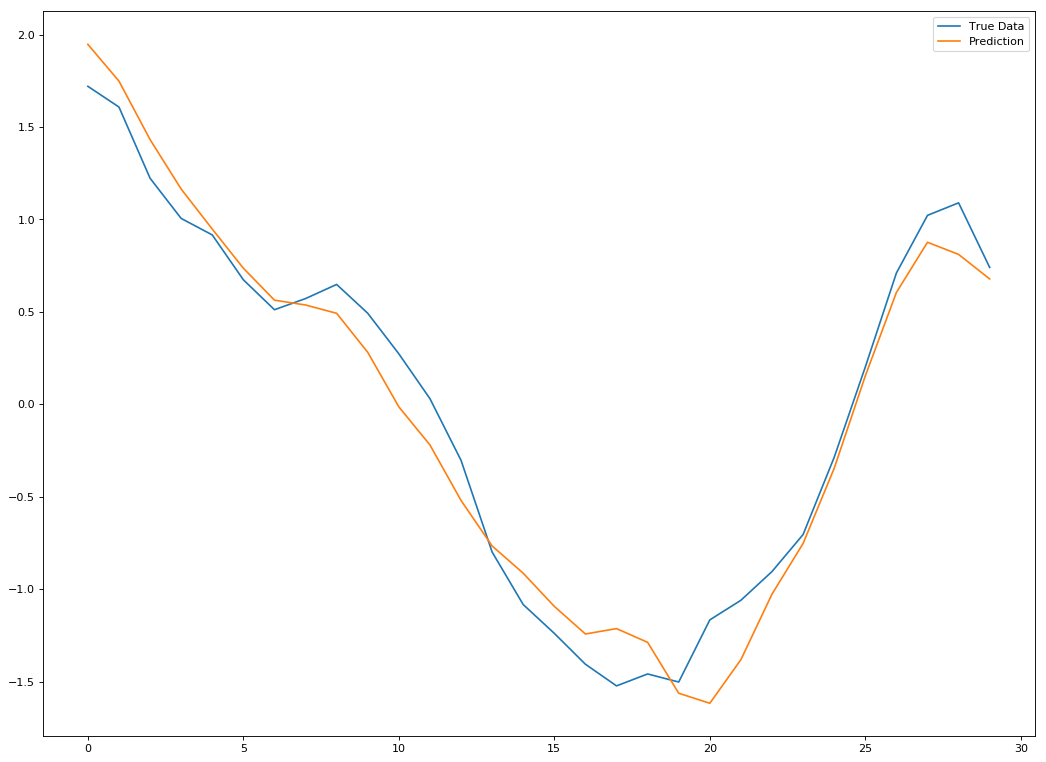

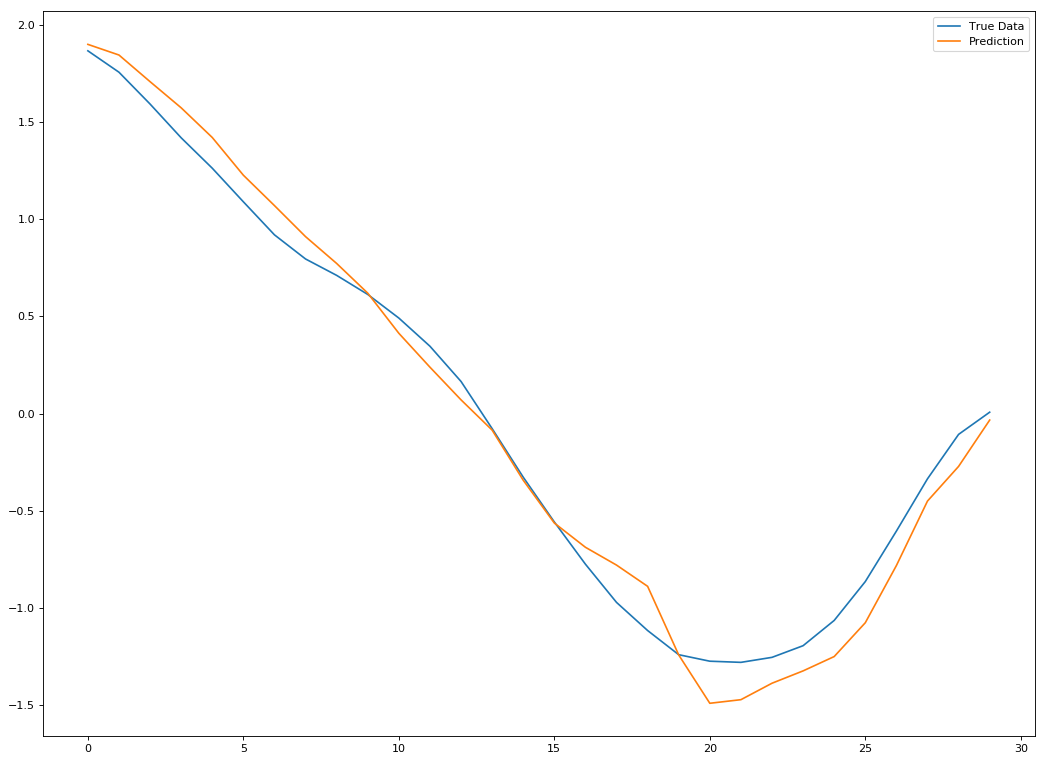

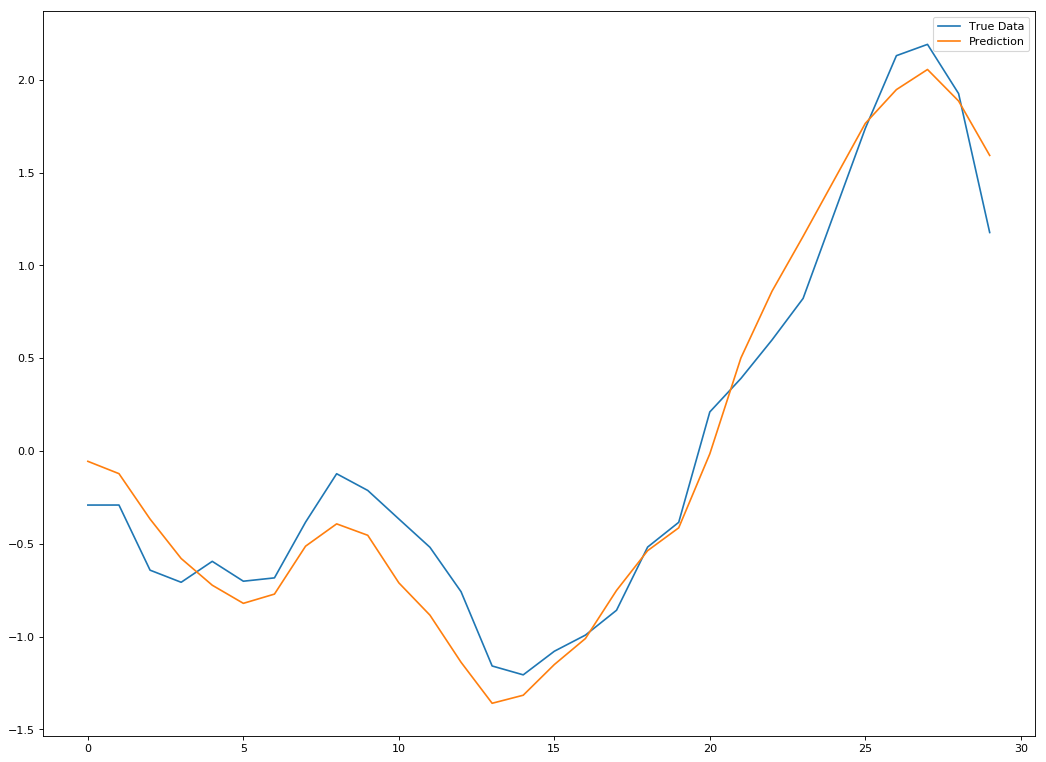

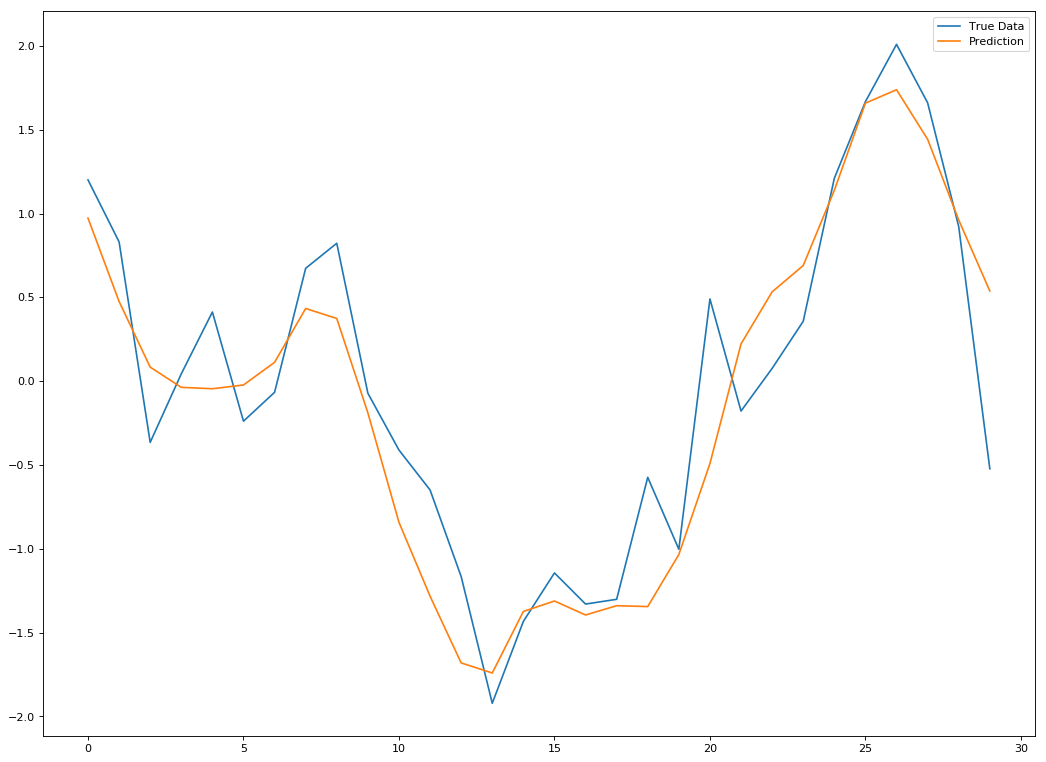

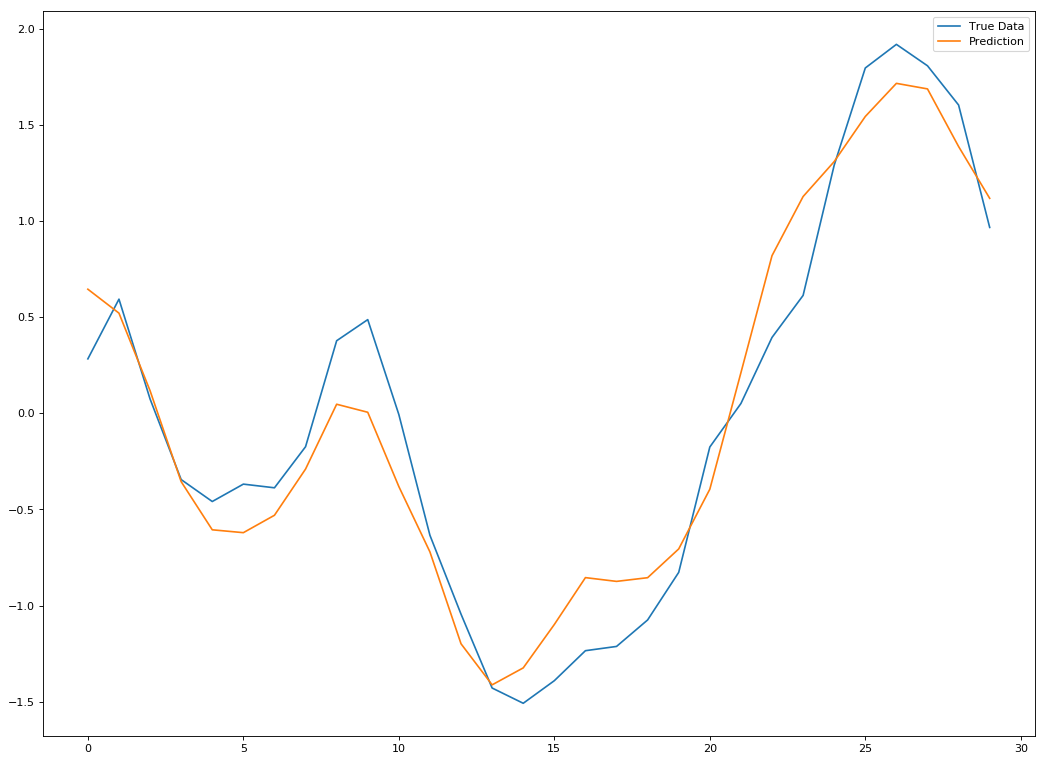

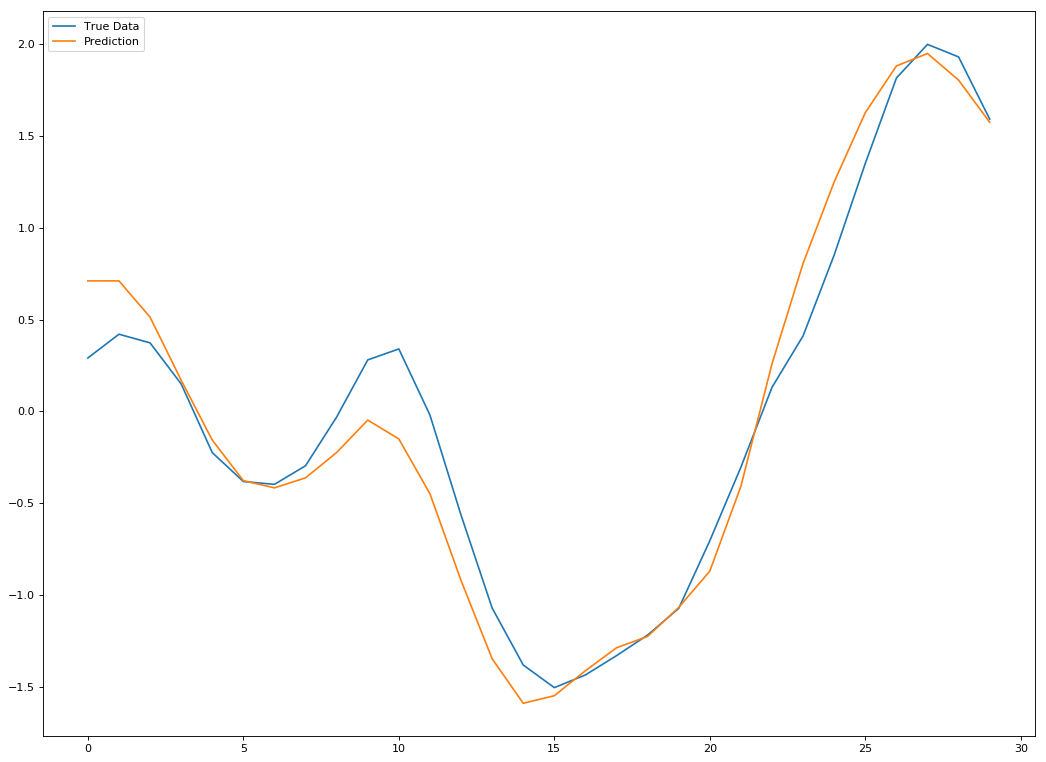

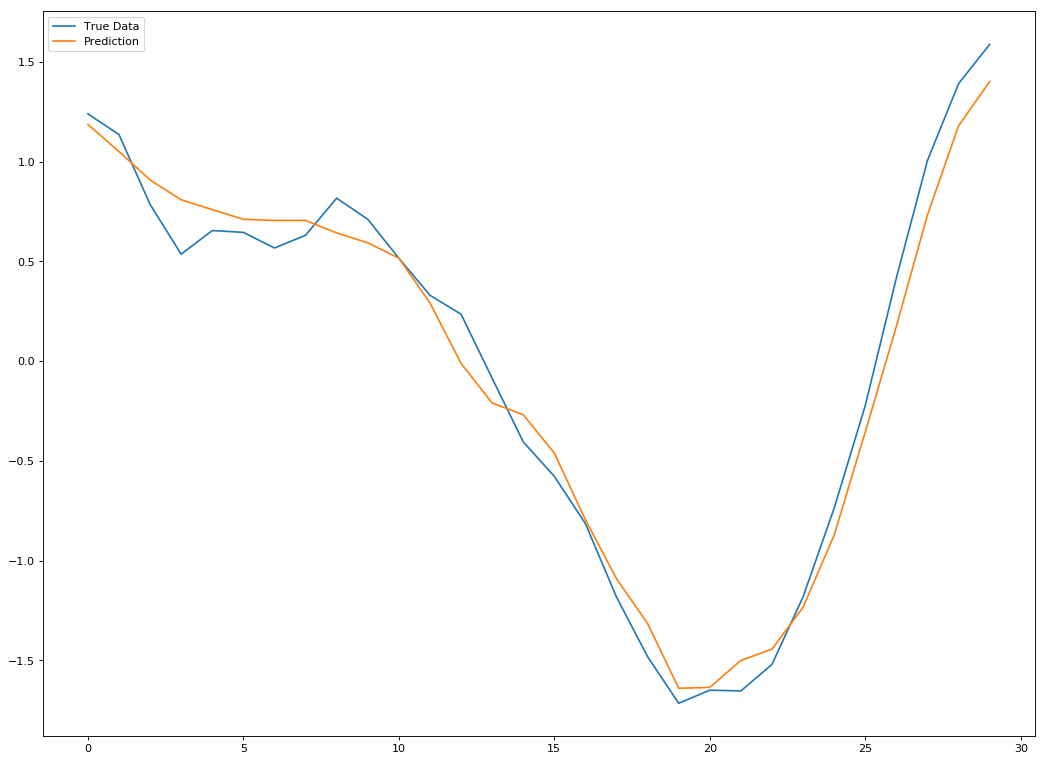

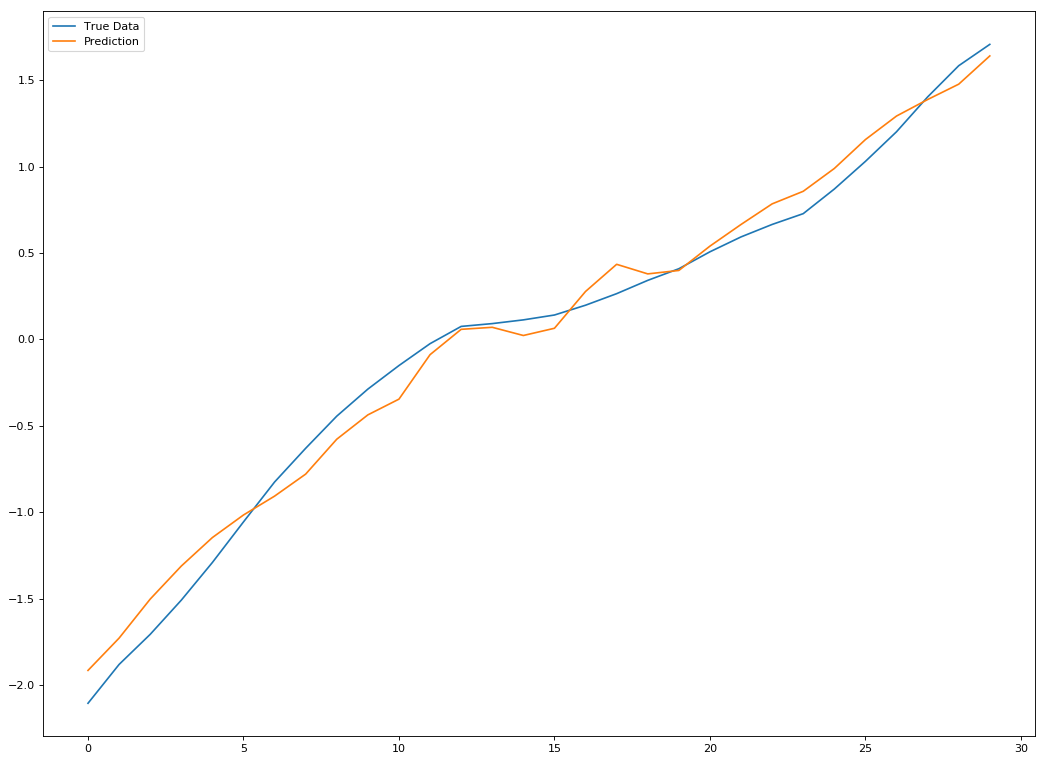

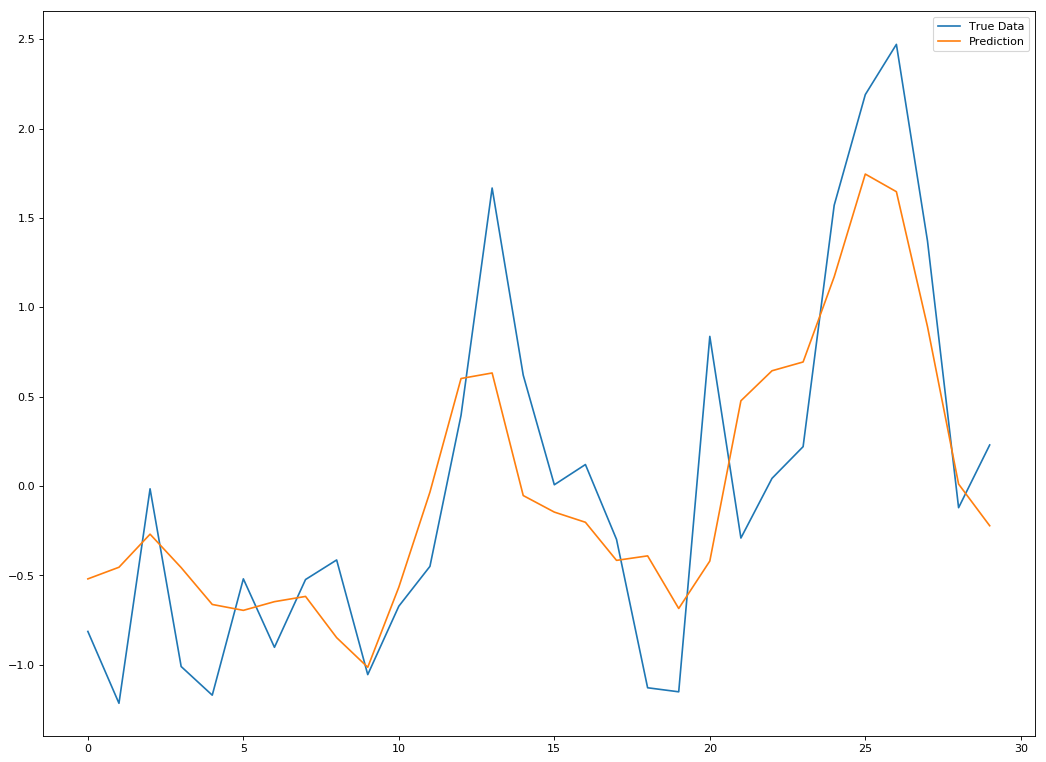

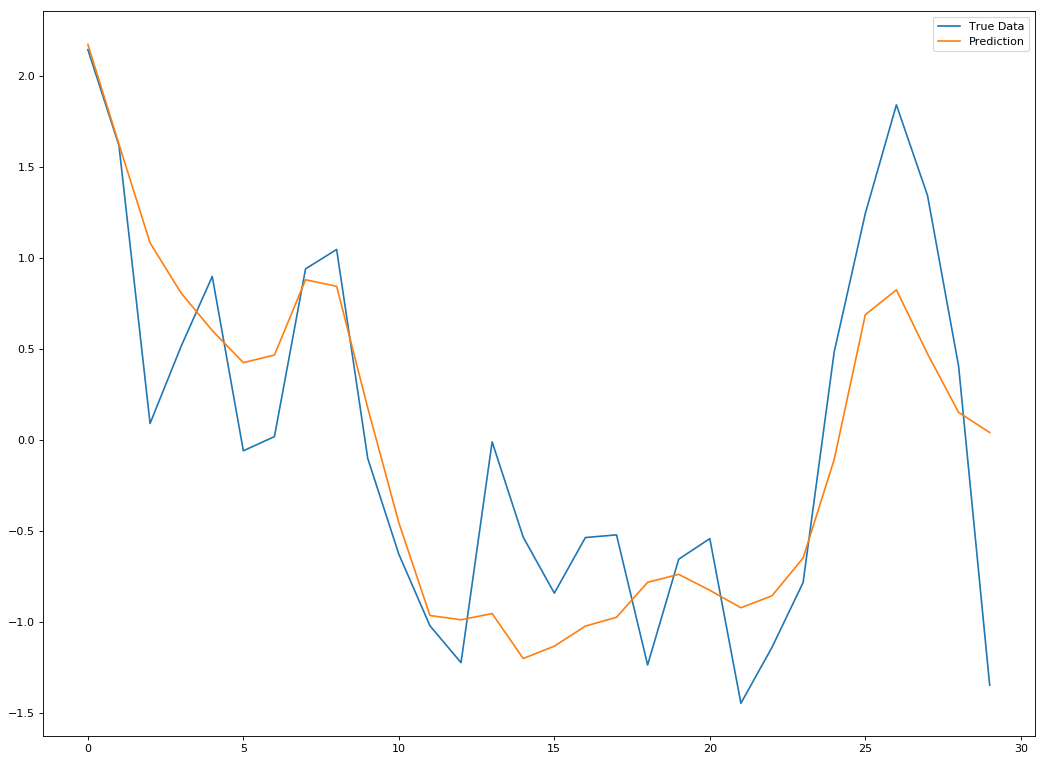

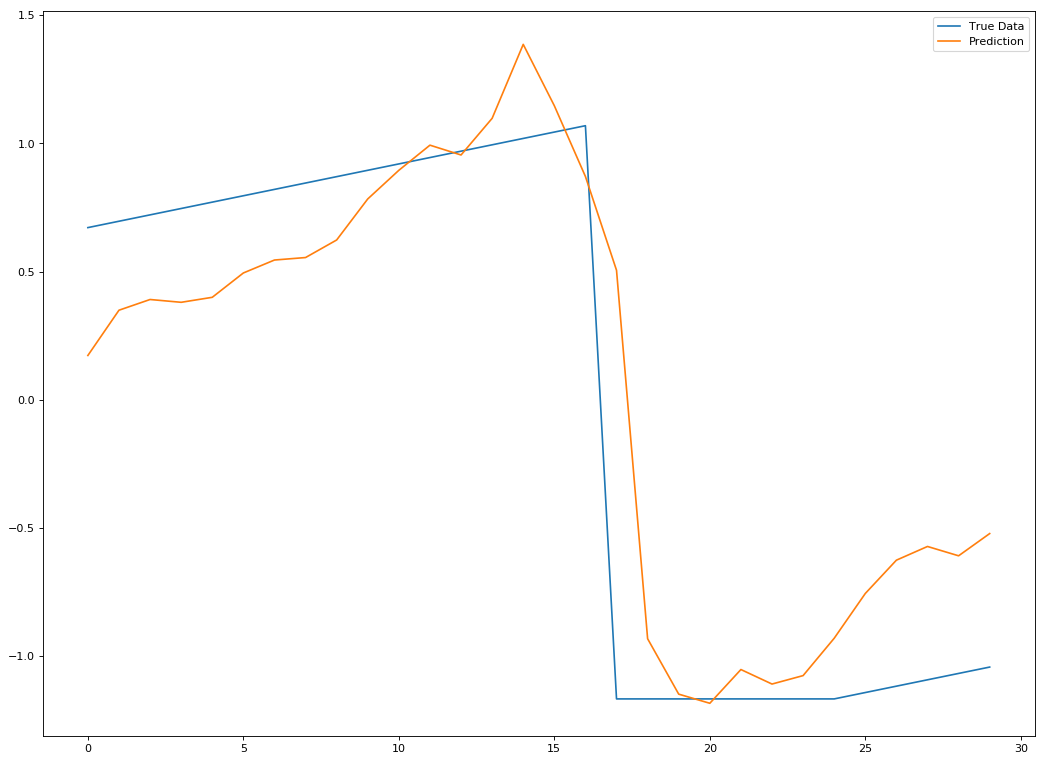

In [0]:
reconstructed_test = autoencoder_model.predict(x_test)

for i in range(x_test.shape[2]):
  plot_results(reconstructed_test[0,:,i], x_test[0,:,i])

### Create Embeddings

In [0]:
x_train = encoder.predict(x_train)
x_test = encoder.predict(x_test)

### Save Models

In [0]:
autoencoder_model.save('bi_lstm_autoencoders_first_half.h5')
encoder.save('bi_lstm_encoder_first_half.h5')

### Create Prediction Model

In [0]:
model = create_model(x_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_134 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_135 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 513       
Total params: 525,825
Trainable params: 525,825
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [0]:
callbacks_list = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
]

history = model.fit(x_train,
                    y_train,
                    batch_size=256,
                    epochs=5000,
                    shuffle=True,
                    callbacks=callbacks_list,
                    validation_split=0.1,
                    verbose=1)

model.save('bi_lstm_prediction_first_half.h5')

Train on 1644 samples, validate on 183 samples
Epoch 1/5000
1644/1644 [==============================] - 7s 4ms/sample - loss: 1.2379 - val_loss: 0.7469
Epoch 2/5000
1644/1644 [==============================] - 0s 29us/sample - loss: 0.5034 - val_loss: 0.5503
Epoch 3/5000
1644/1644 [==============================] - 0s 28us/sample - loss: 0.3581 - val_loss: 0.4765
Epoch 4/5000
1644/1644 [==============================] - 0s 26us/sample - loss: 0.2989 - val_loss: 0.4266
Epoch 5/5000
1644/1644 [==============================] - 0s 25us/sample - loss: 0.2564 - val_loss: 0.4137
Epoch 6/5000
1644/1644 [==============================] - 0s 25us/sample - loss: 0.2351 - val_loss: 0.4035
Epoch 7/5000
1644/1644 [==============================] - 0s 25us/sample - loss: 0.2167 - val_loss: 0.3783
Epoch 8/5000
1644/1644 [==============================] - 0s 25us/sample - loss: 0.2050 - val_loss: 0.3743
Epoch 9/5000
1644/1644 [==============================] - 0s 27us/sample - loss: 0.1919 - val_loss

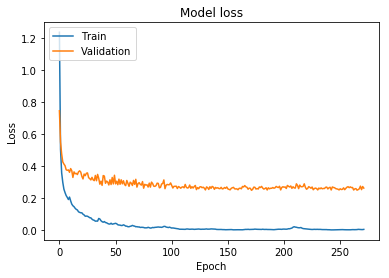

In [0]:
plot_loss(history)

### Predict for Test Set

In [0]:
predicted = model.predict(x_test)

### Rescale Data

In [0]:
new_predicted = []

for i in range(len(predicted)):
  temp = np.zeros((x_train.shape[2],))
  # 3 for closing price
  temp[3] = predicted[i]
  new_predicted.append(scalars[len(x_train)+i].inverse_transform(temp)[3])
  
predicted = np.array(new_predicted)

### Plot Predictions

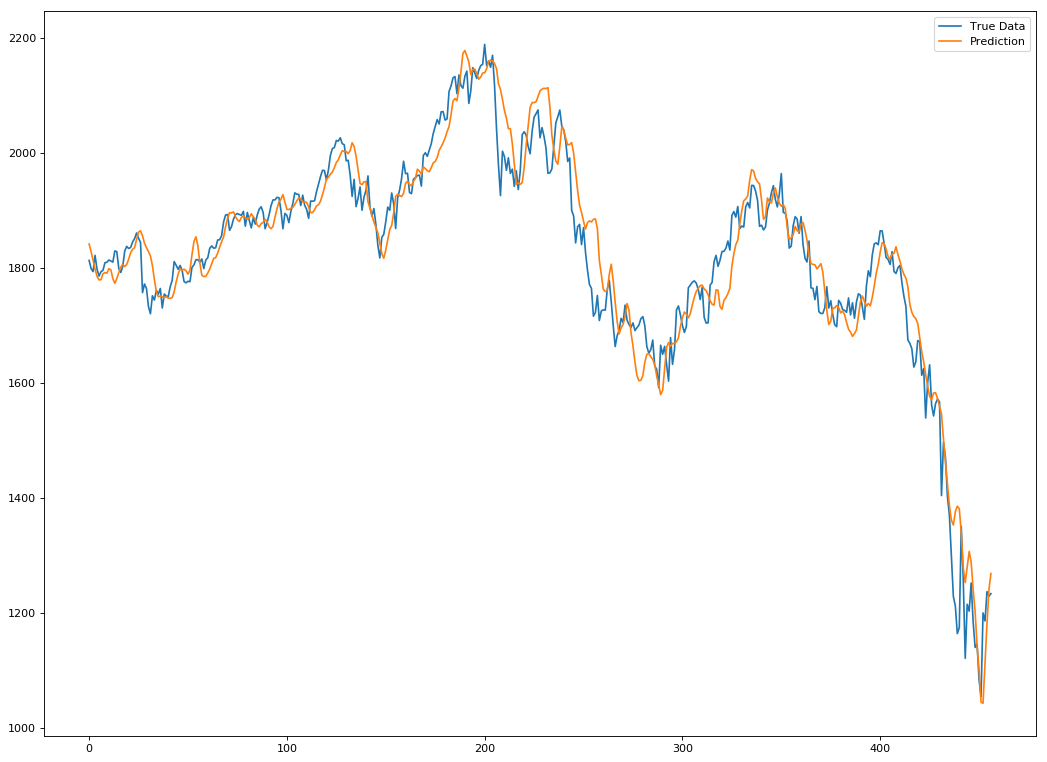

In [0]:
plot_results(predicted, original_data)

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted, original_data)

2559.6801131264933

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data - predicted) / original_data)) * 100)

2.138716749335473


### Convert to Directional Data

In [0]:
predicted_directions = directional_data(predicted, original_data)

No change: 58
Up: 187
Down: 211


In [0]:
actual_directions = directional_data(original_data, original_data)

No change: 95
Up: 185
Down: 176


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions.argmax(axis=1)
predicted_classes = classes[indices]

indices = actual_directions.argmax(axis=1)
y_true = classes[indices]

By Count

Confusion matrix, without normalization
[[81 26 69]
 [57  7 31]
 [73 25 87]]


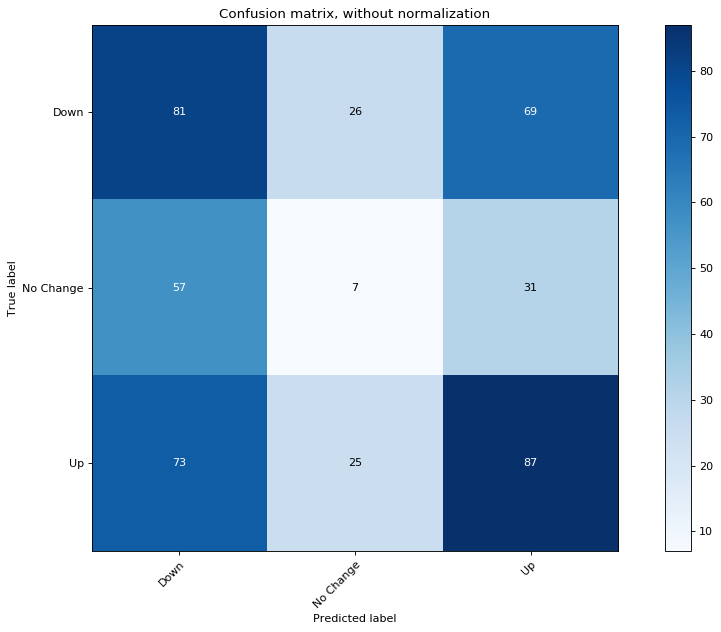

In [0]:
plot_confusion_matrix(y_true, predicted_classes, normalize=False)

Normalized

Normalized confusion matrix
[[0.46022727 0.14772727 0.39204545]
 [0.6        0.07368421 0.32631579]
 [0.39459459 0.13513514 0.47027027]]


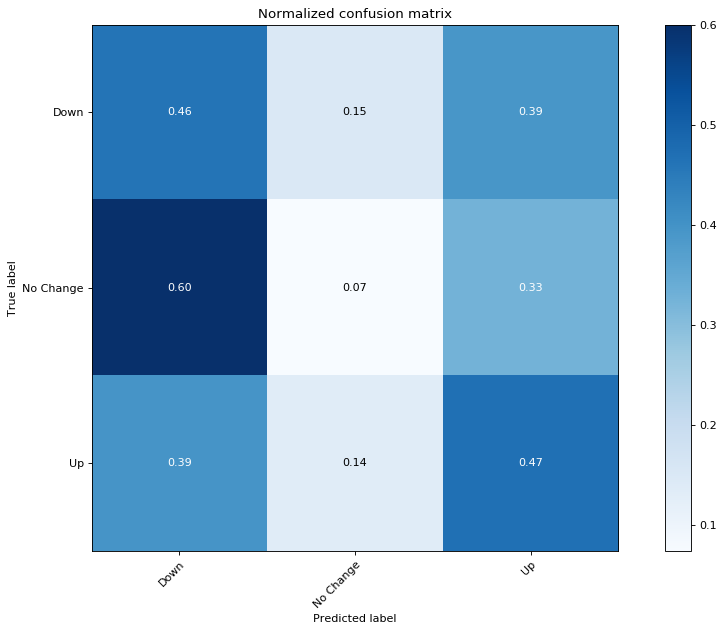

In [0]:
plot_confusion_matrix(y_true, predicted_classes, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, predicted_classes)

0.38377192982456143

### Export to CSV

In [0]:
y_true = np.insert(y_true, 0, 0)
predicted_classes = np.insert(predicted_classes, 0, 0)

In [0]:
columns = ['Date', 'True Closing Values', 'Predicted Closing Values', 'True Values', 'Predicted Values']
data = np.array([dates, original_data, predicted, y_true, predicted_classes]).T

In [0]:
csv = pd.DataFrame(data, columns=columns)

csv.to_csv('bi_lstm_autoencoders_first_half.csv', index=False)

## Download Files

In [0]:
from google.colab import files

files.download('bi_lstm_autoencoders_first_half.csv')

files.download('bi_lstm_autoencoders_first_half.h5')

files.download('bi_lstm_encoder_first_half.h5')

files.download('bi_lstm_prediction_first_half.h5')

## Second Half

### Load Data

In [0]:
x_train_2, y_train_2, x_test_2, y_test_2, scalars_2, original_data_2, dates_2 = load_data(df.values[int(len(df)/2):], seq_len, all_data[int(len(df)/2):])

### Create Bidirectional LSTM Autoencoders

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 30, 16)            0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 30, 1024)          2166784   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 512)               2623488   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 30, 512)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 30, 512)           1574912   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 30, 1024)          4198400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 16)            16400     
Total para

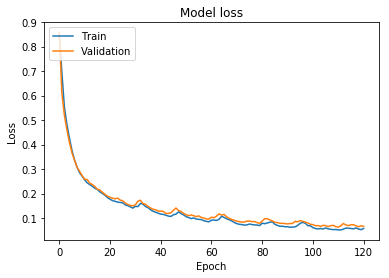

In [0]:
autoencoder_model_2, encoder_2 = autoencoder(x_train_2)

In [0]:
autoencoder_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 30, 16)            0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 30, 1024)          2166784   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 512)               2623488   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 30, 512)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 30, 512)           1574912   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 30, 1024)          4198400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 16)            16400     
Total para

In [0]:
encoder_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 30, 16)            0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 30, 1024)          2166784   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 512)               2623488   
Total params: 4,790,272
Trainable params: 4,790,272
Non-trainable params: 0
_________________________________________________________________


### Reconstruction

#### Training Data

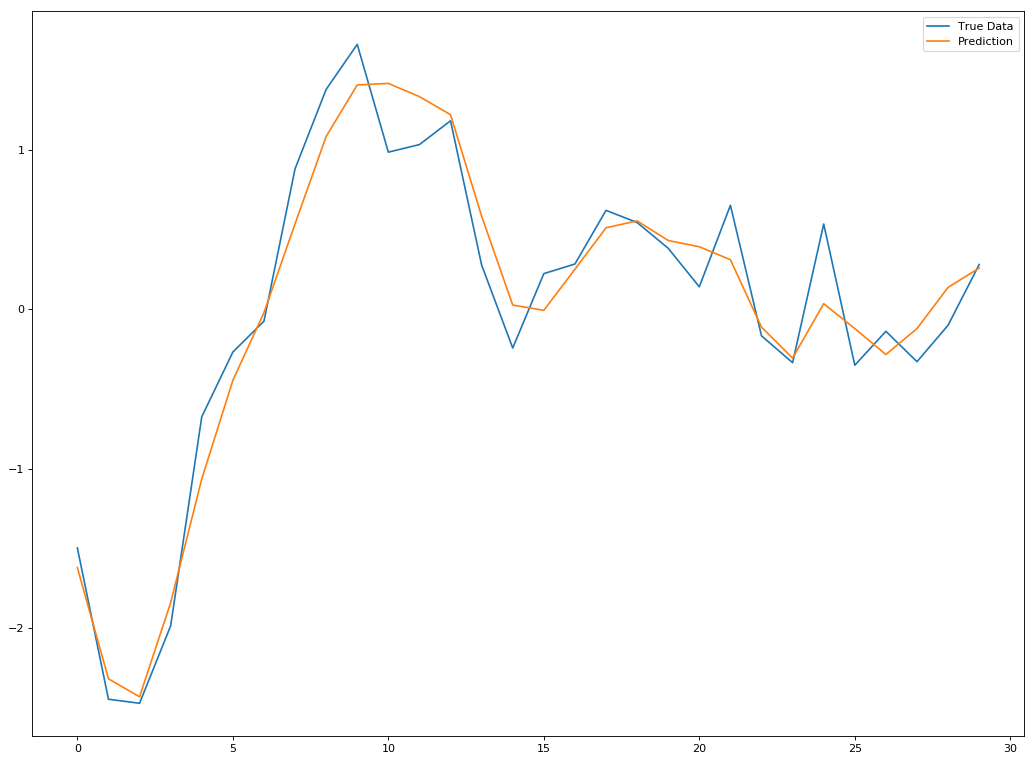

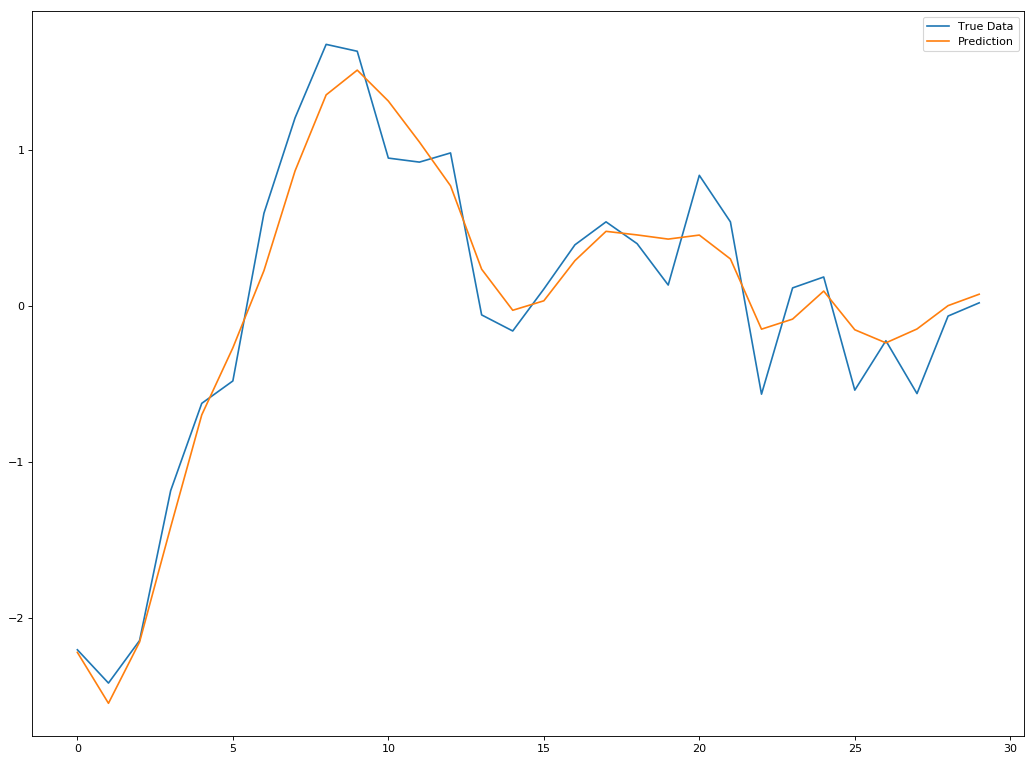

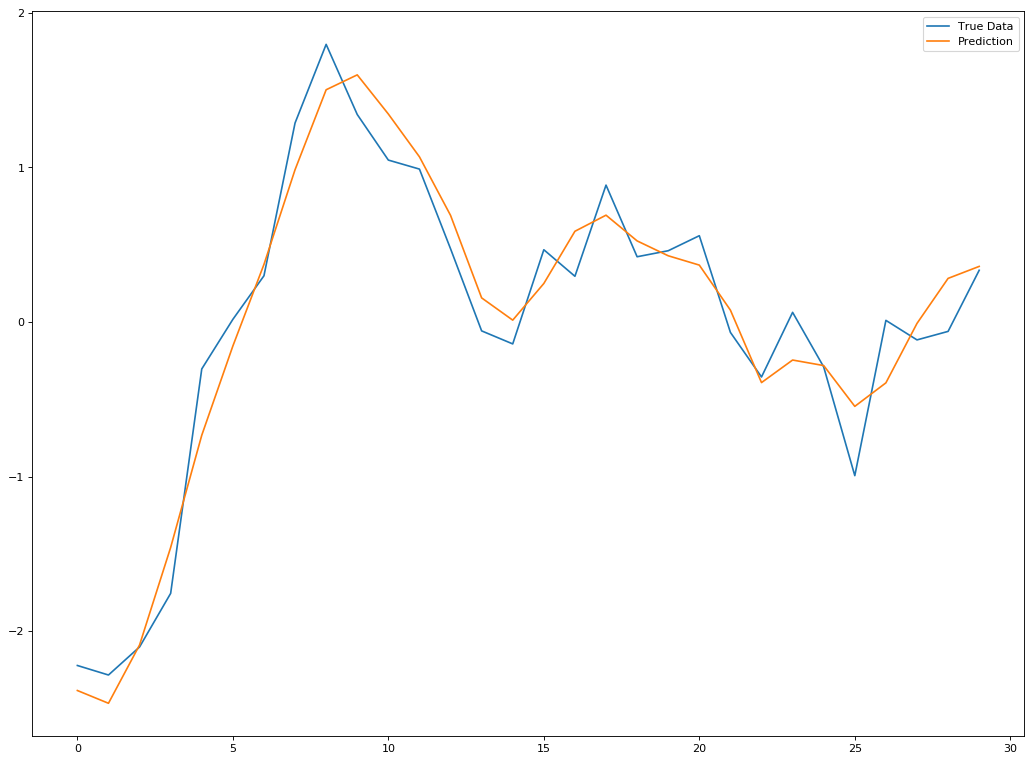

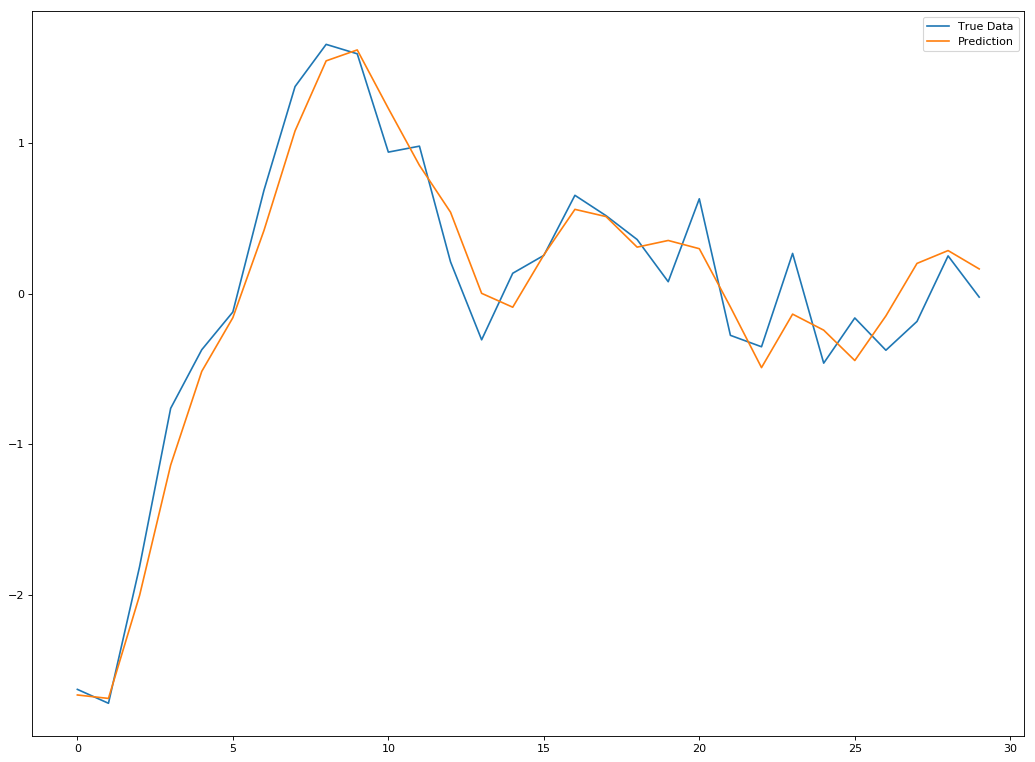

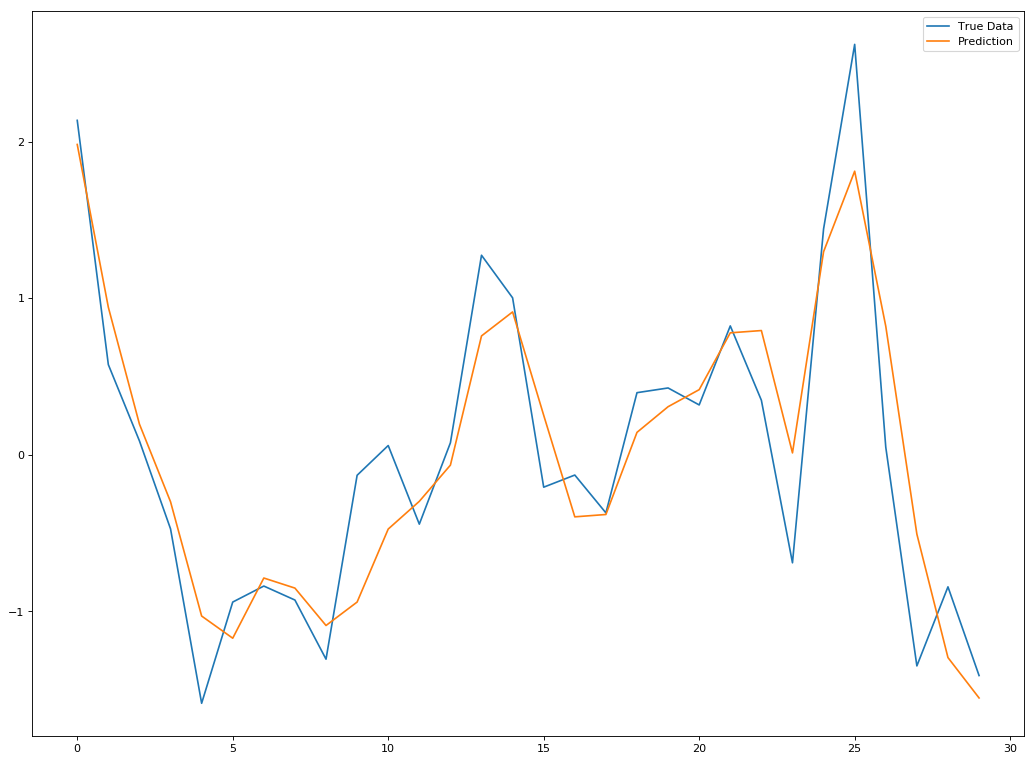

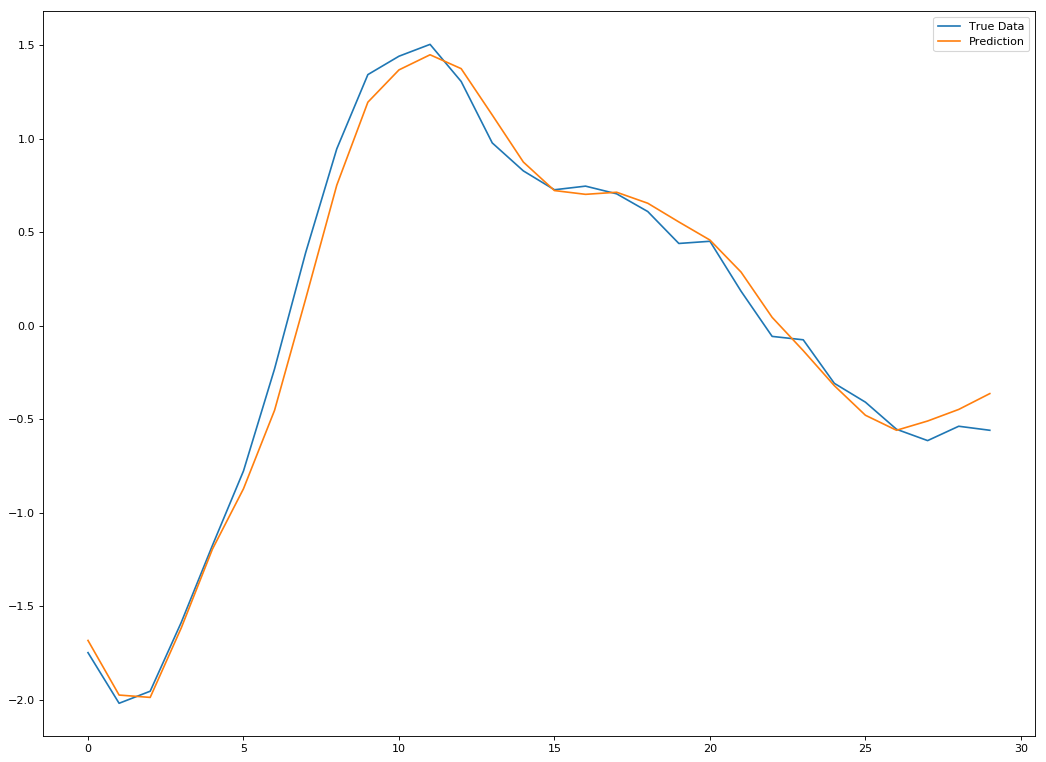

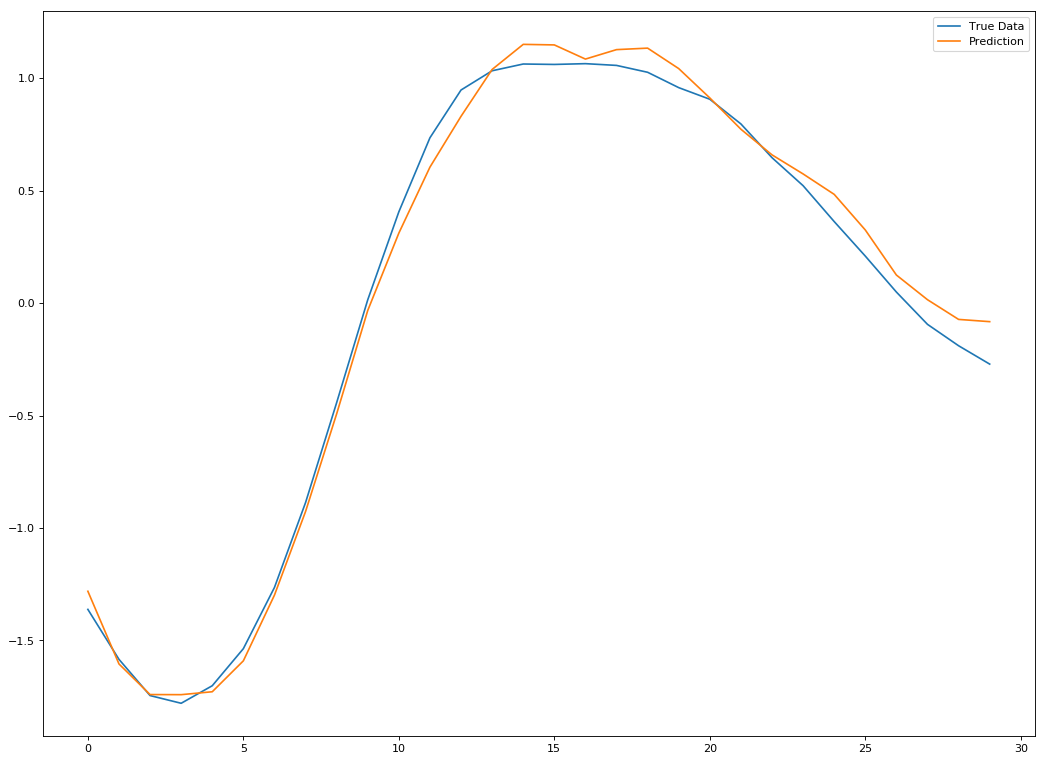

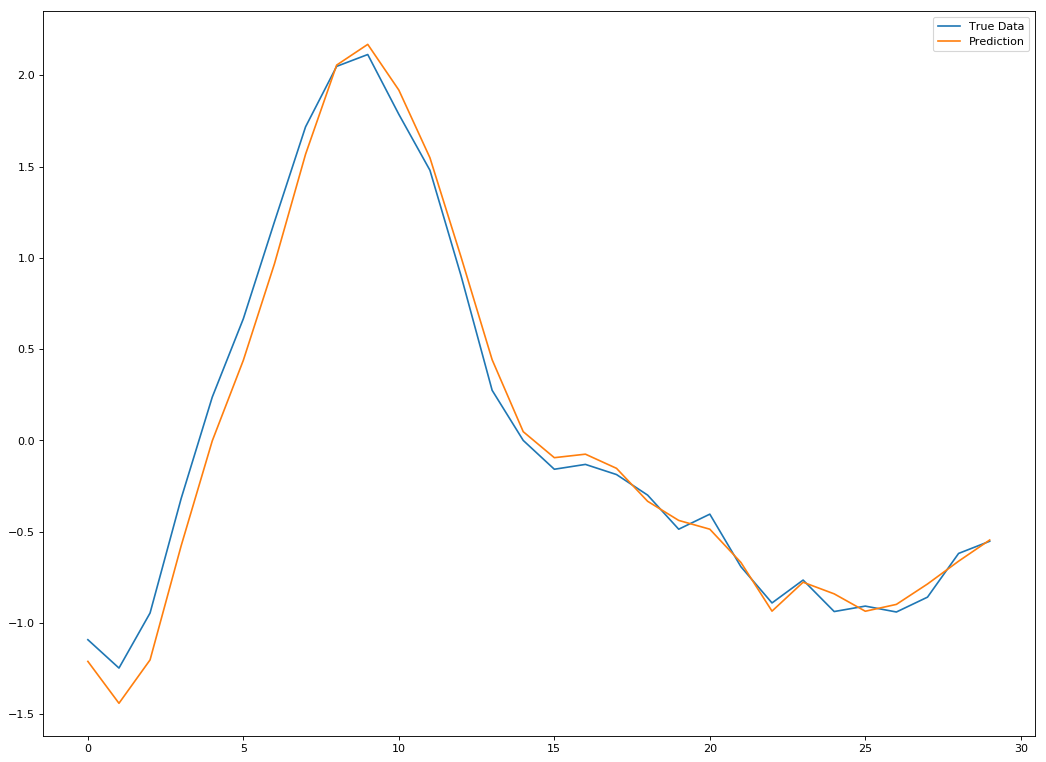

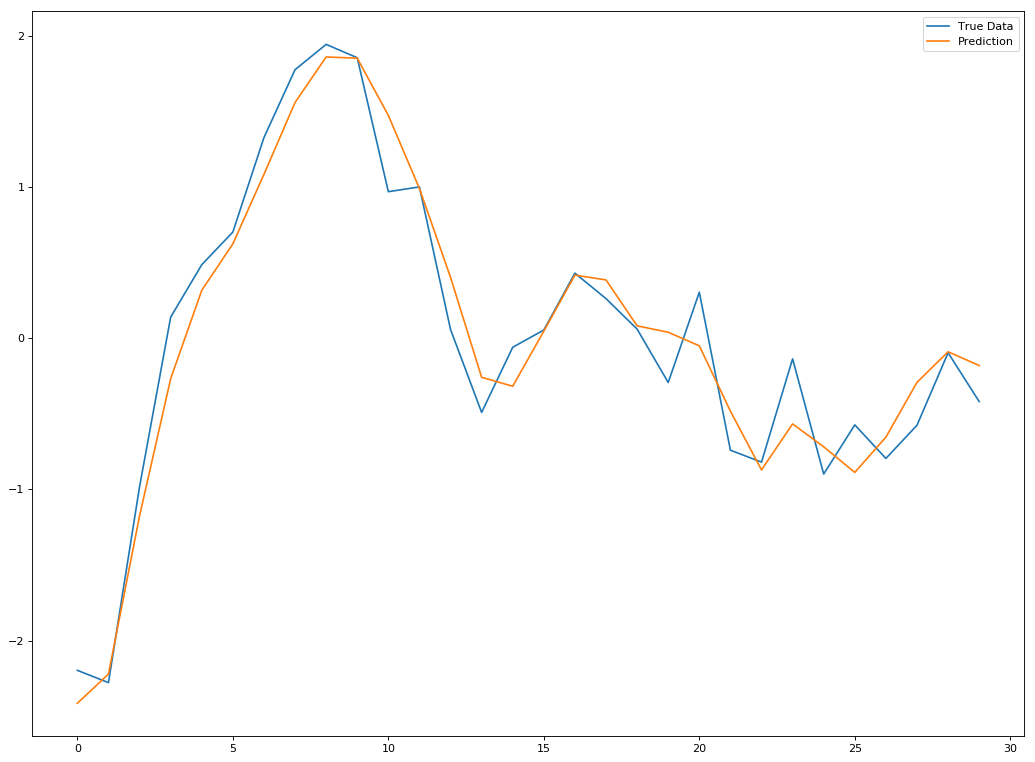

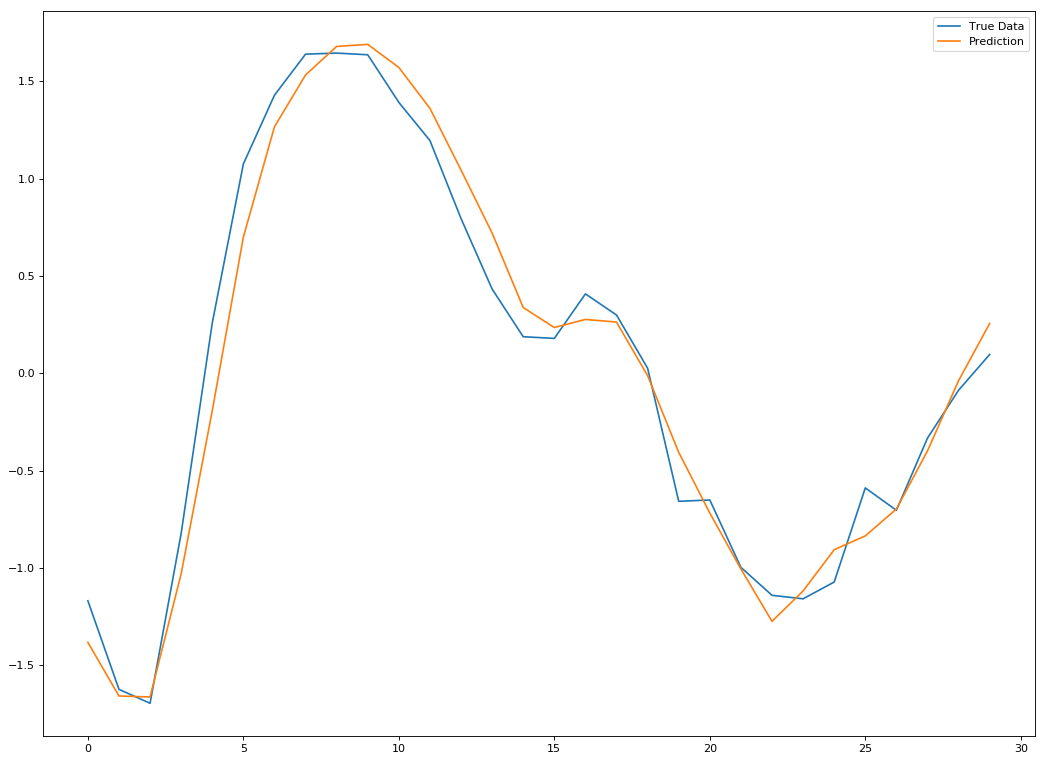

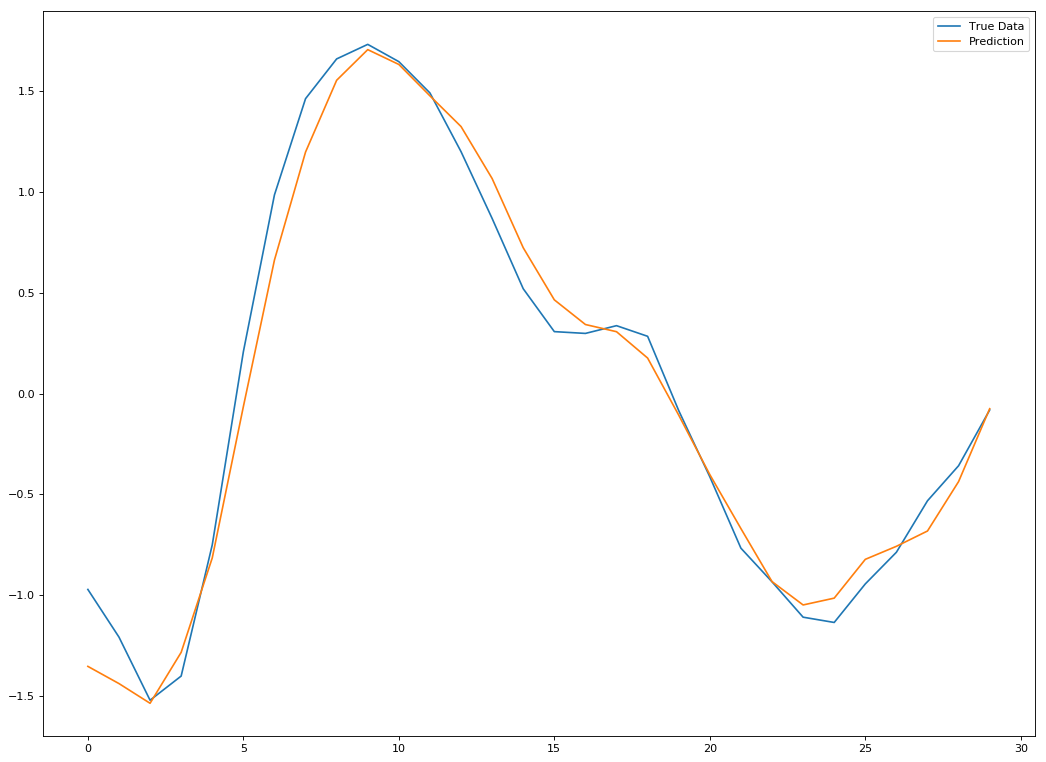

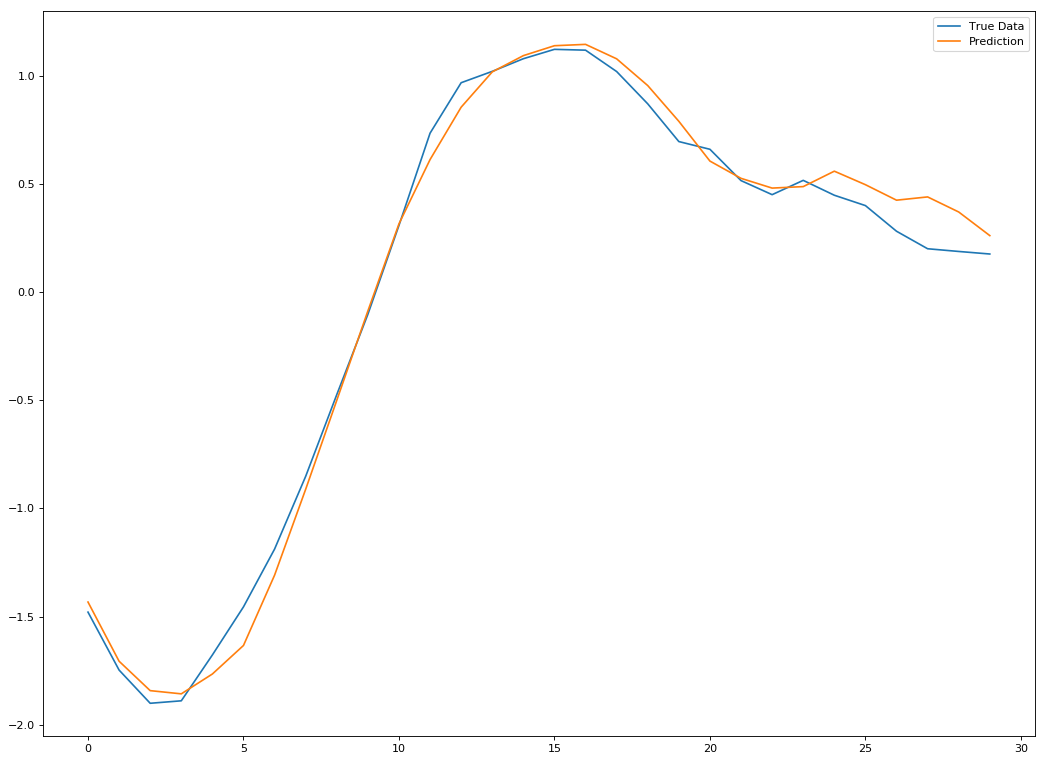

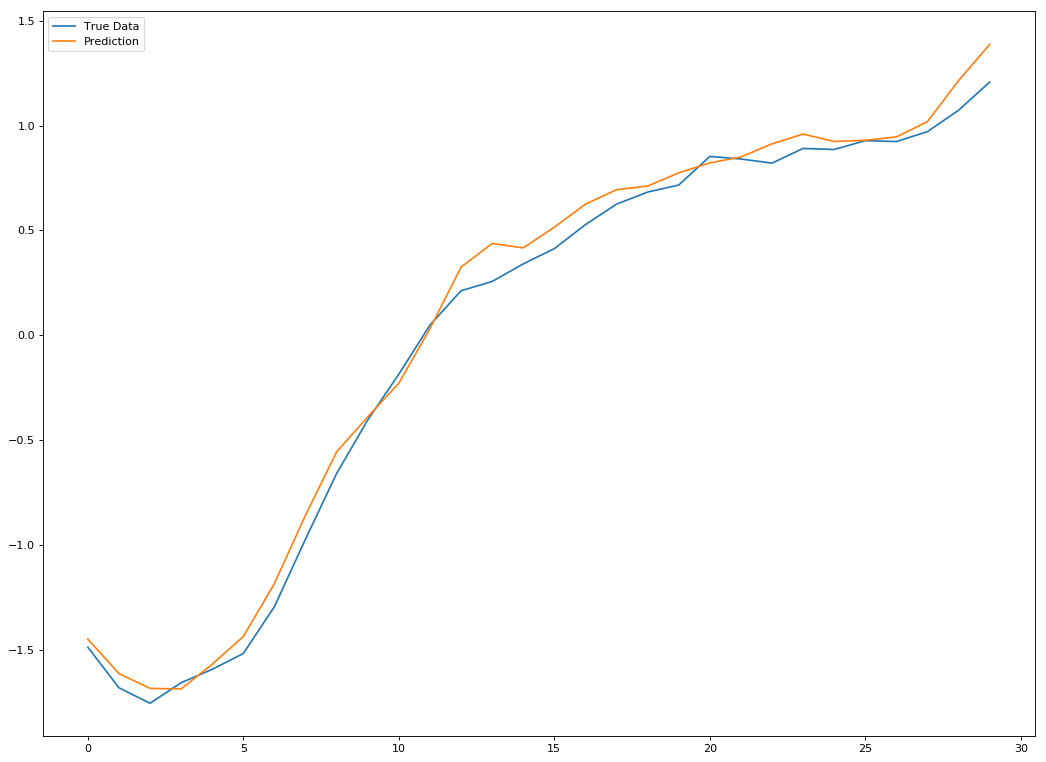

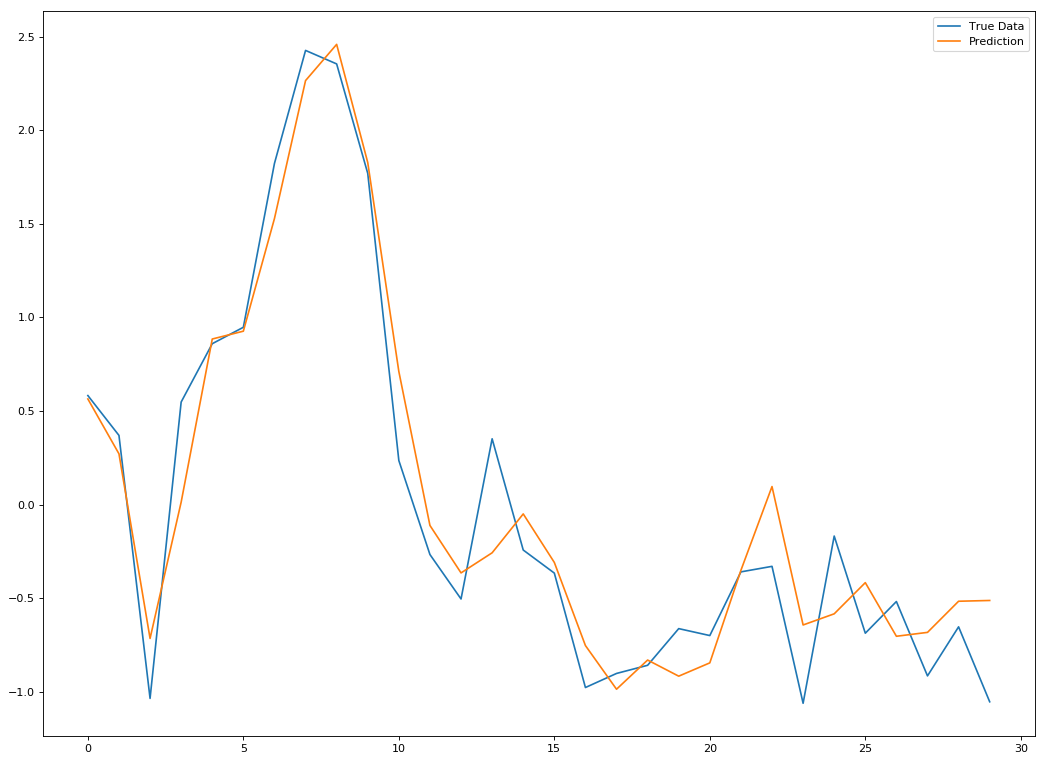

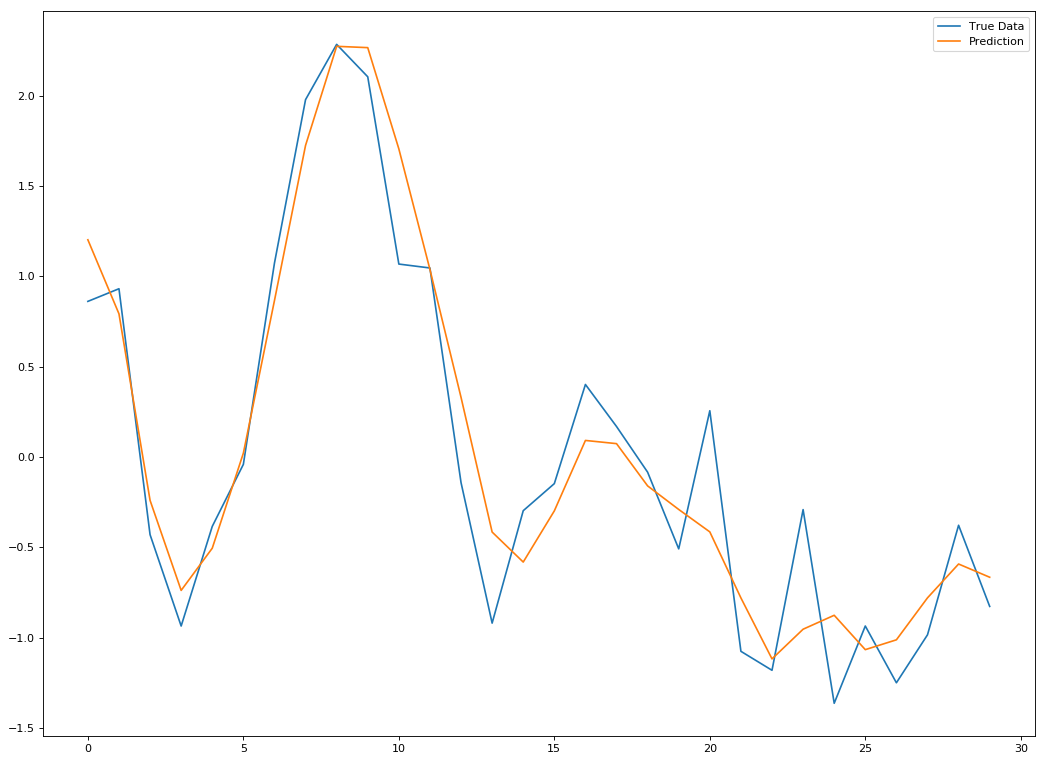

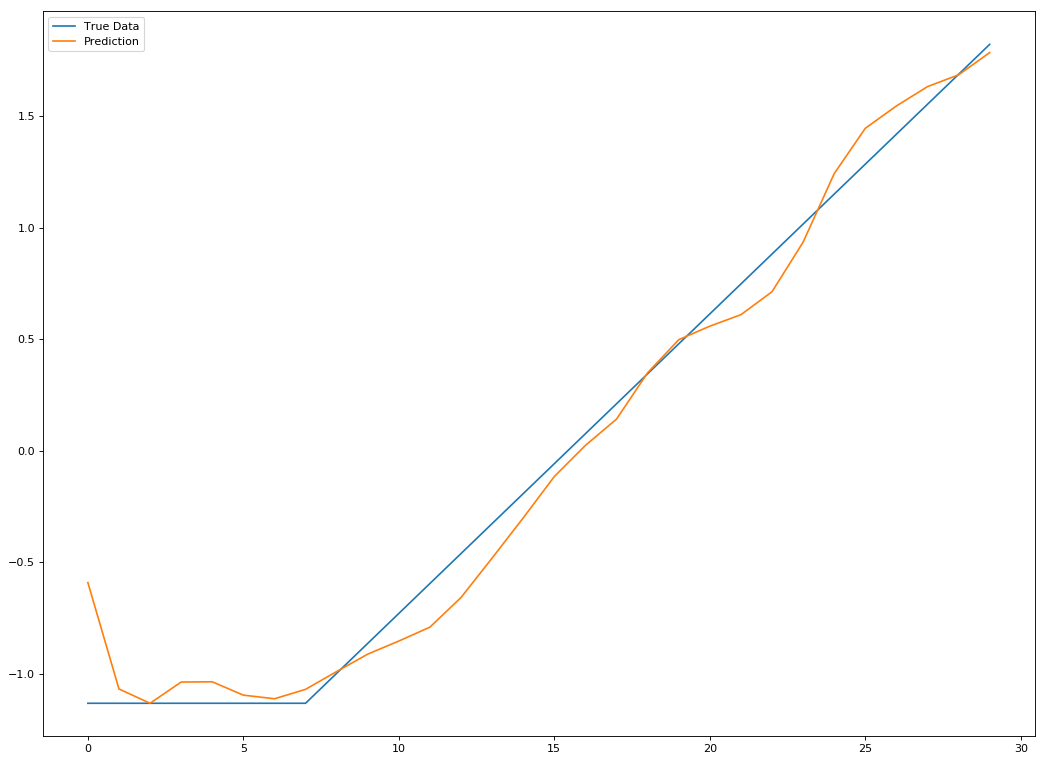

In [0]:
reconstructed_train_2 = autoencoder_model_2.predict(x_train_2)

for i in range(x_train_2.shape[2]):
  plot_results(reconstructed_train_2[0,:,i], x_train_2[0,:,i])

#### Testing Data

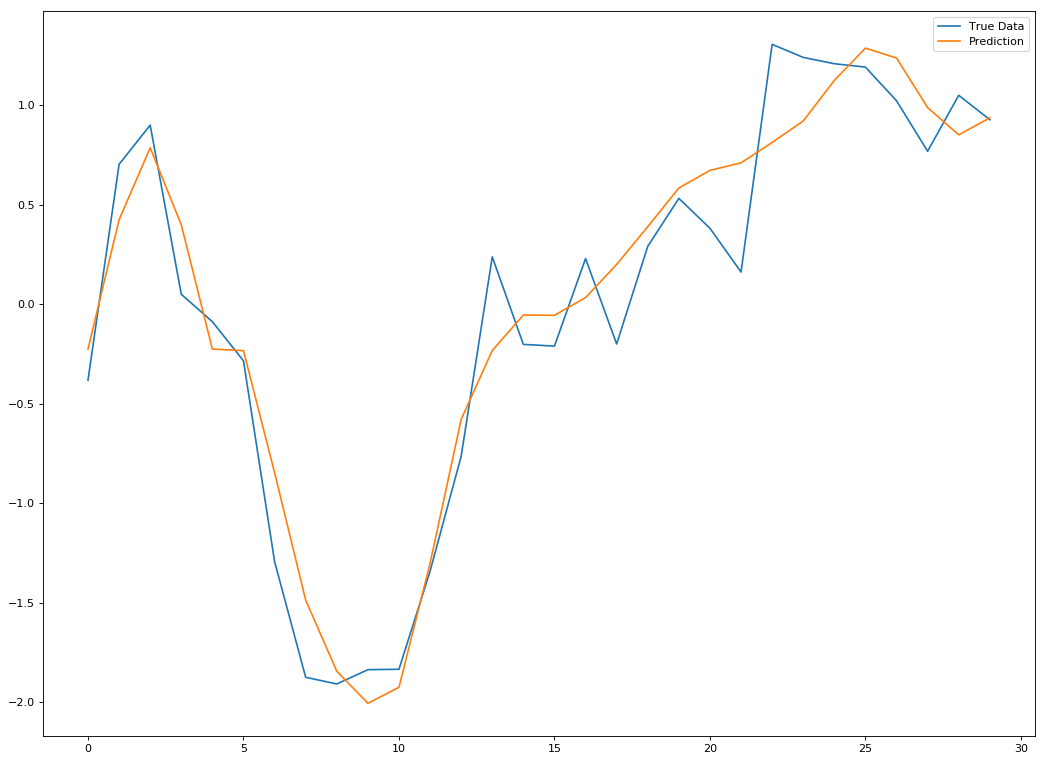

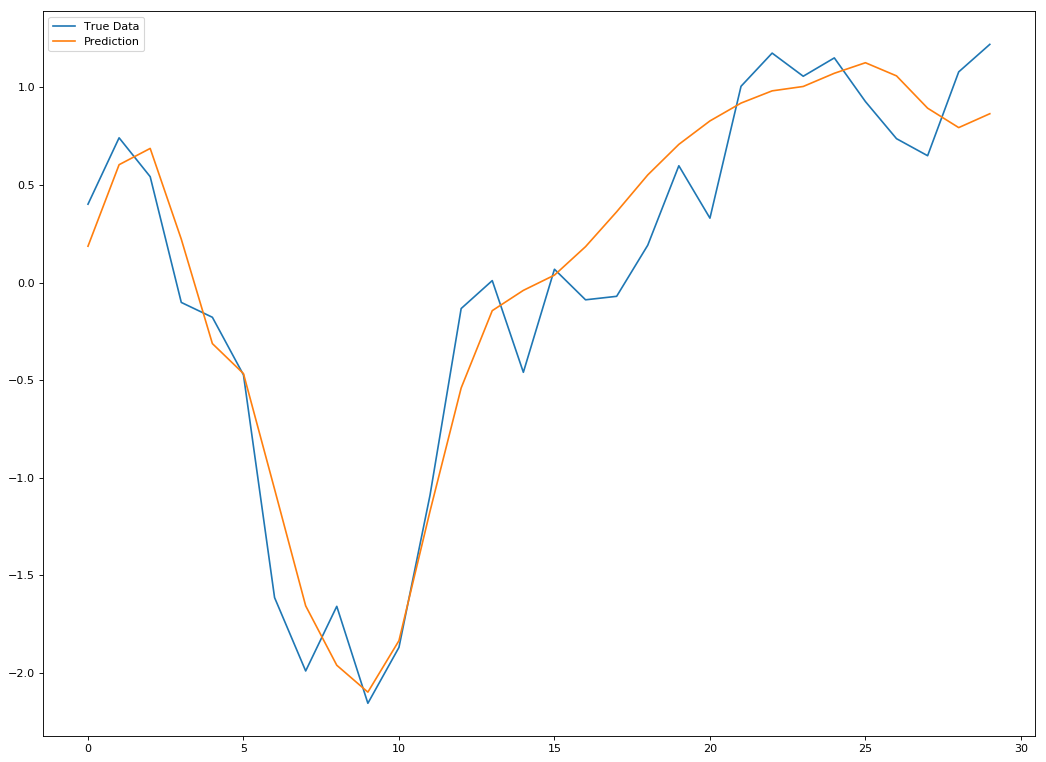

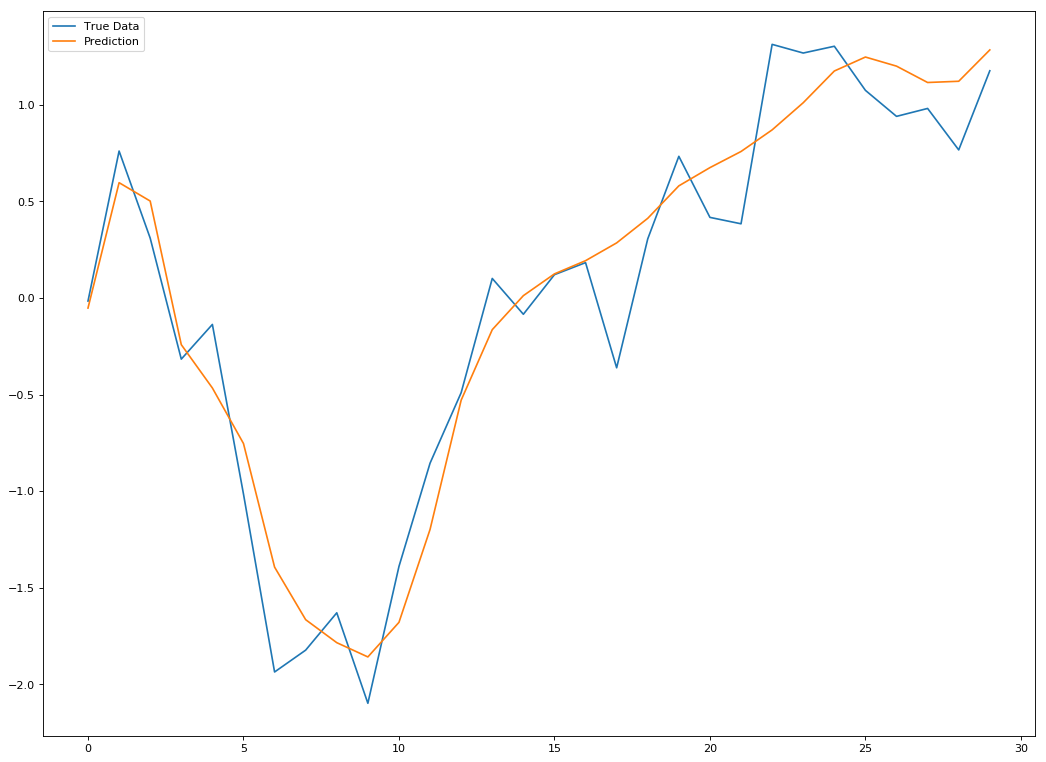

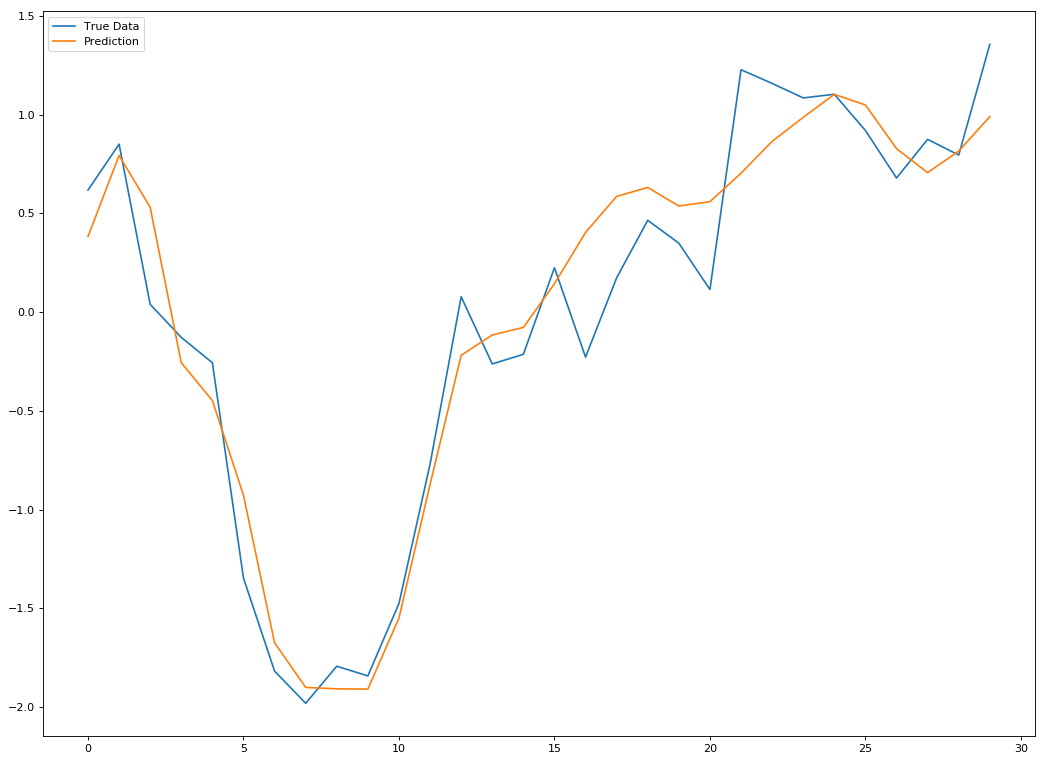

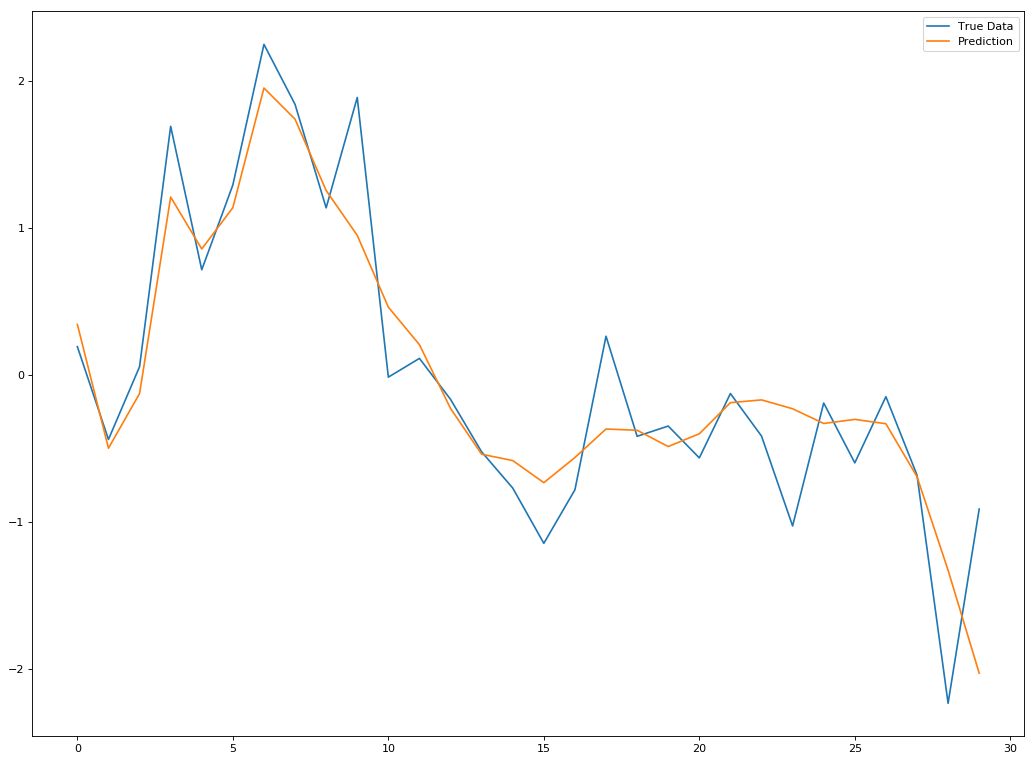

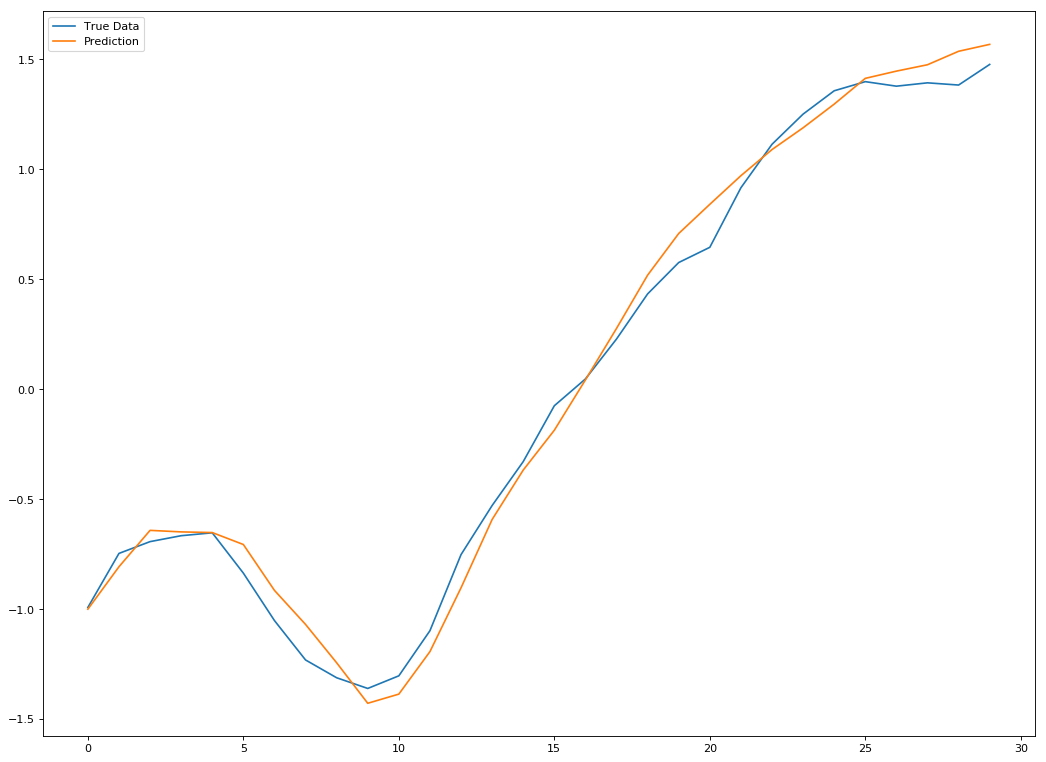

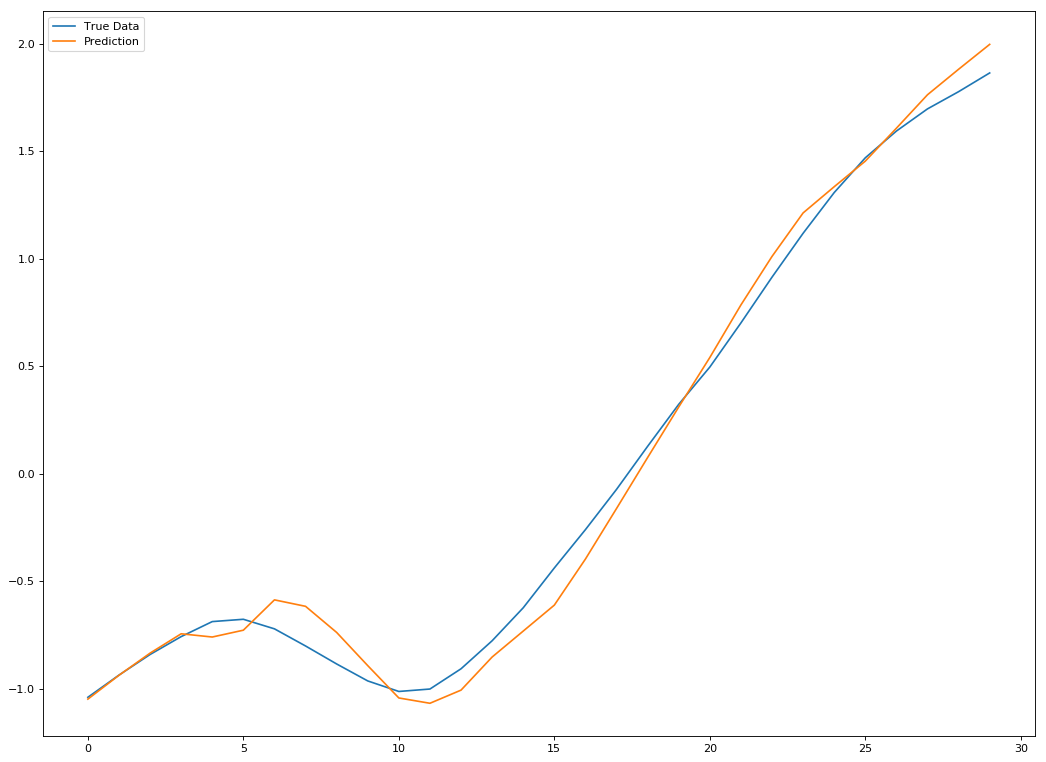

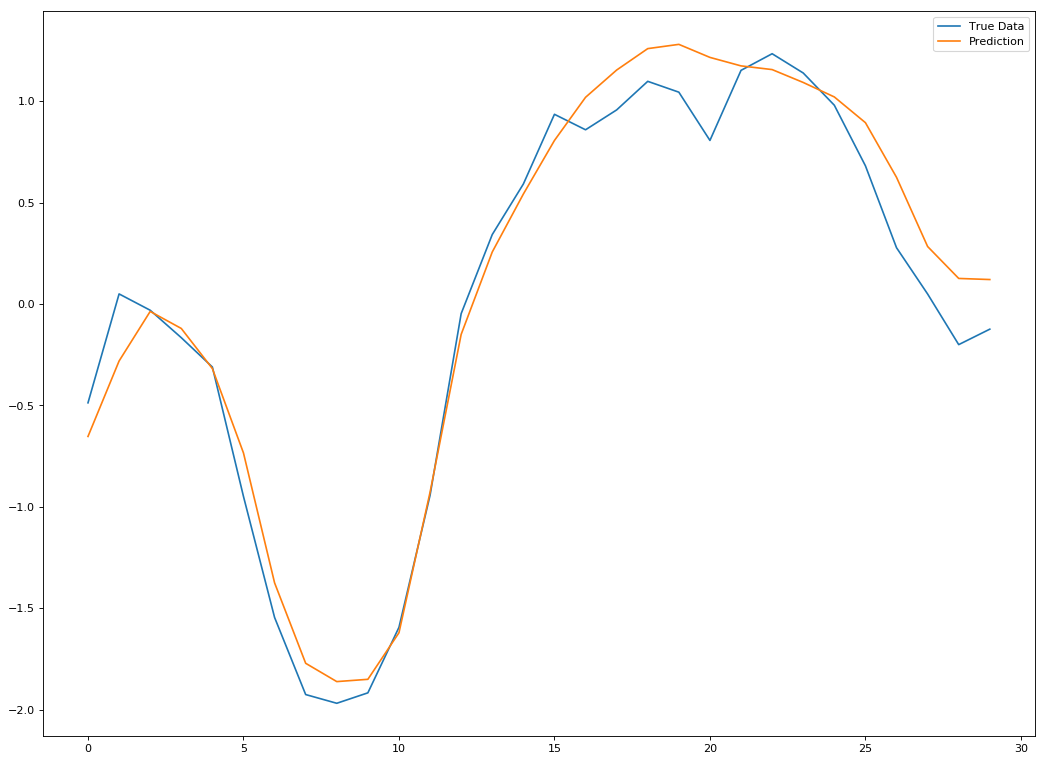

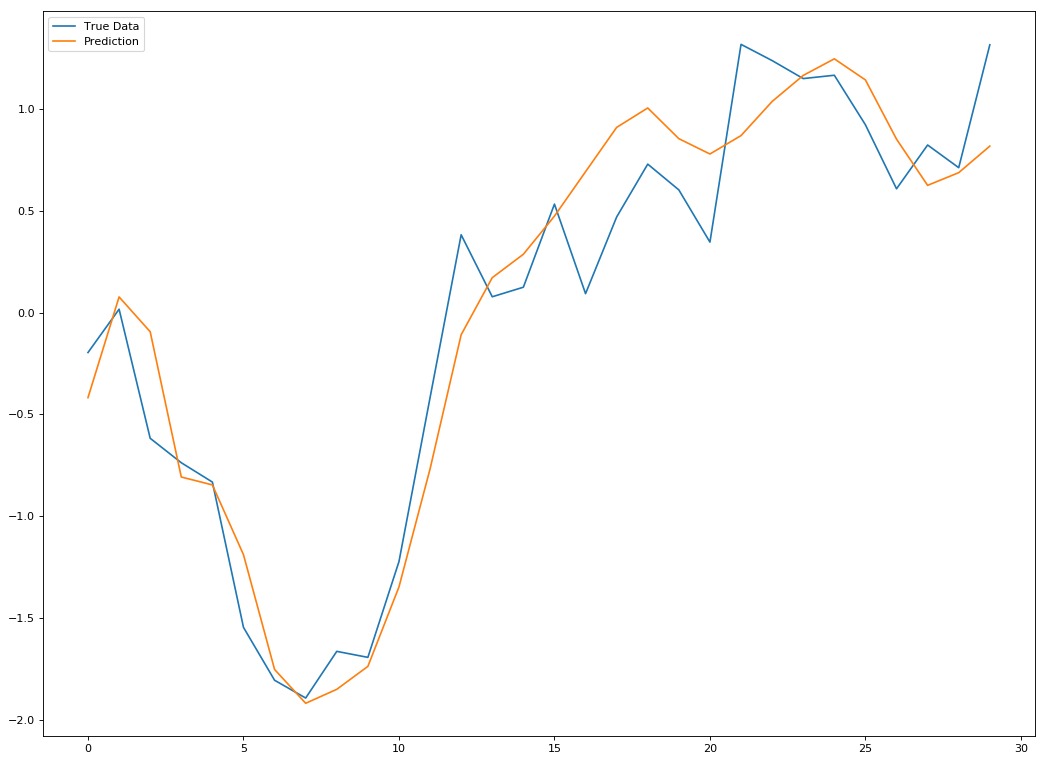

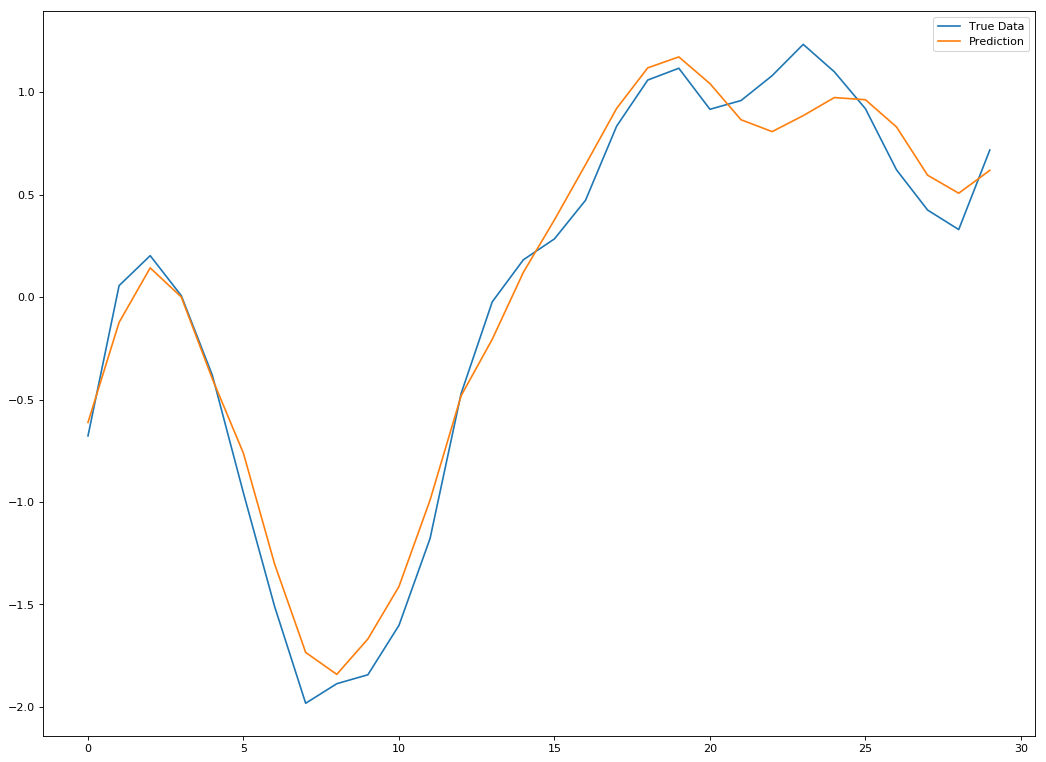

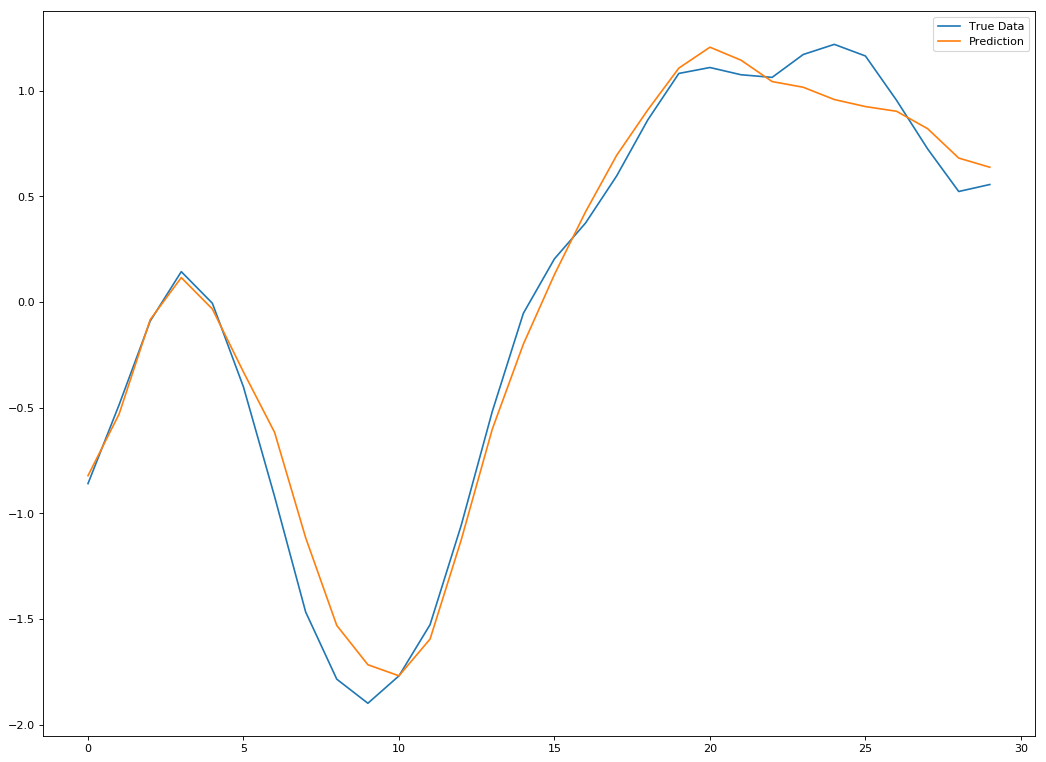

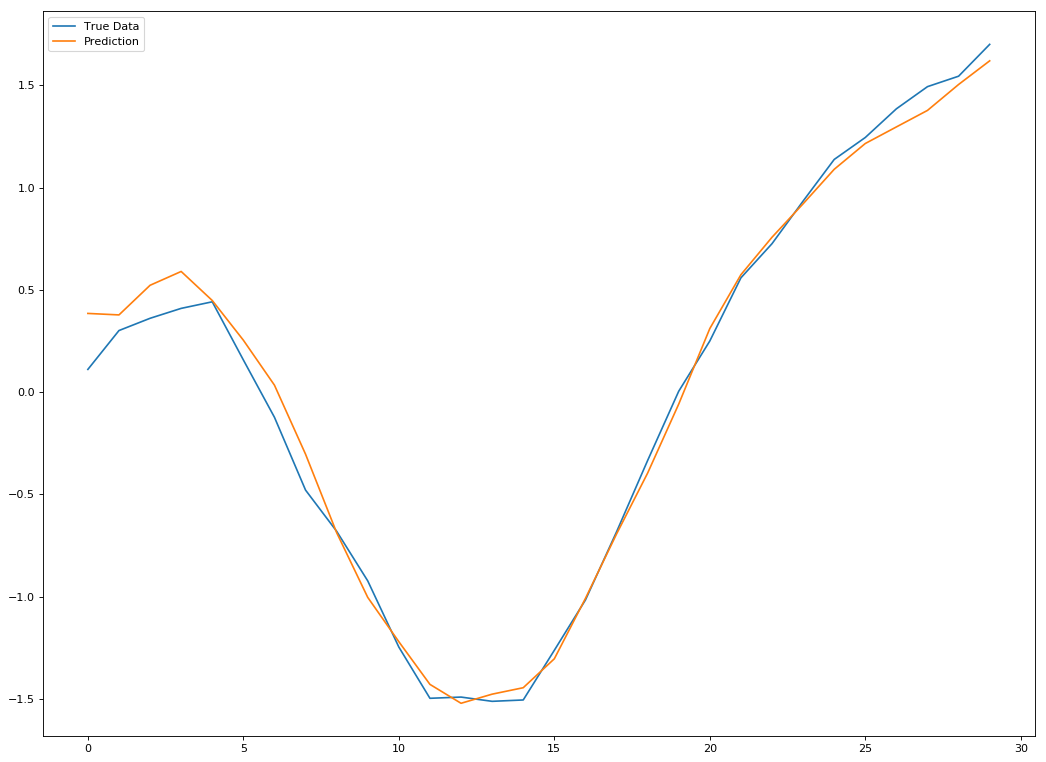

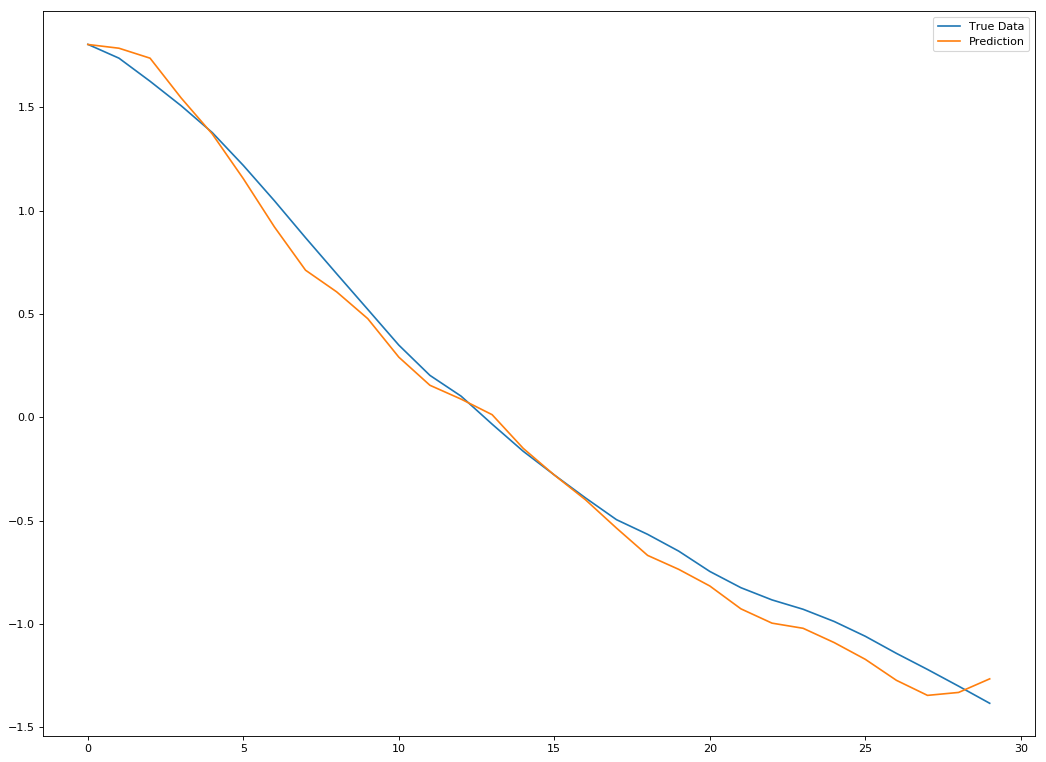

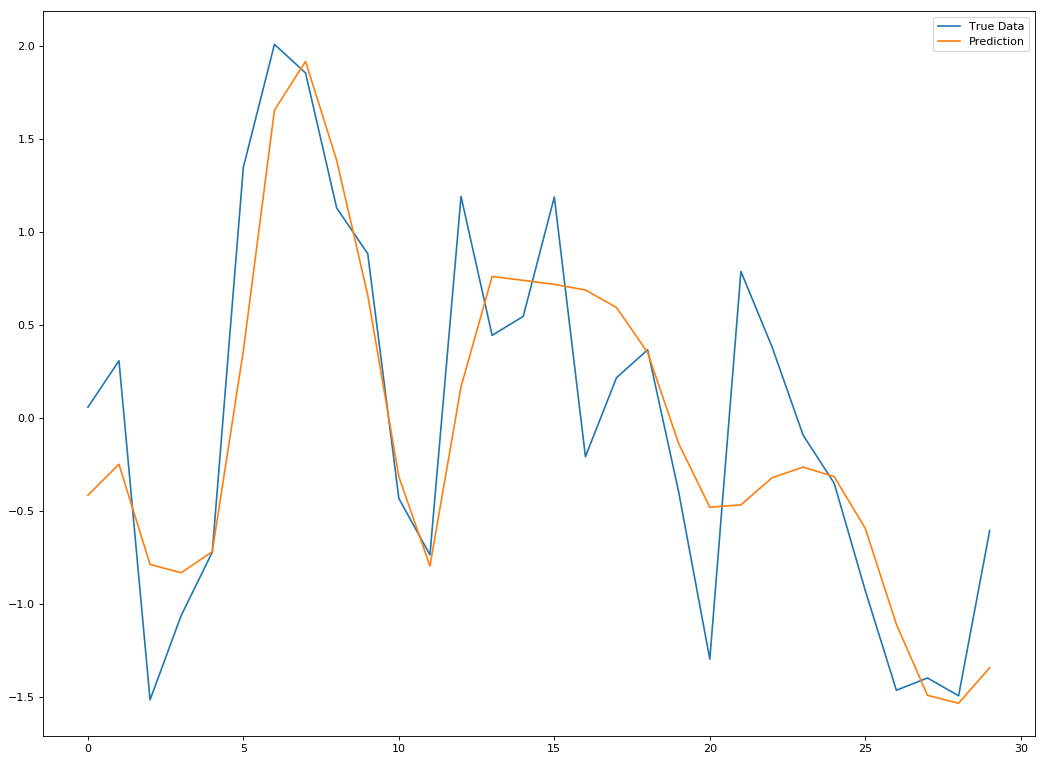

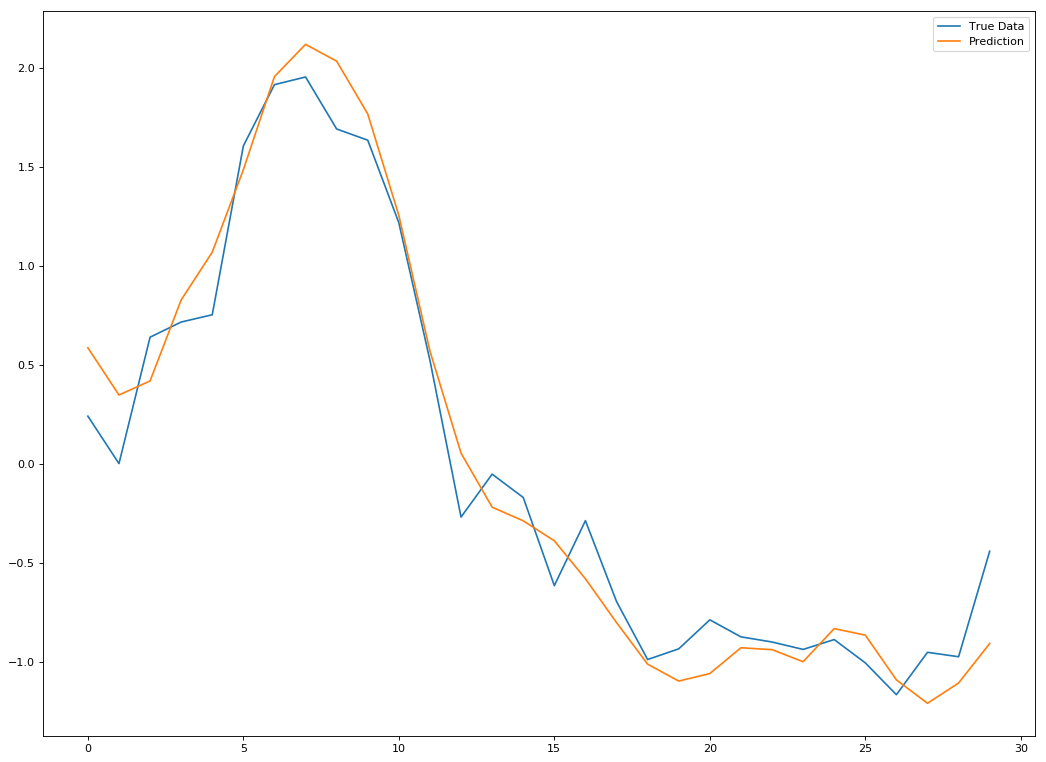

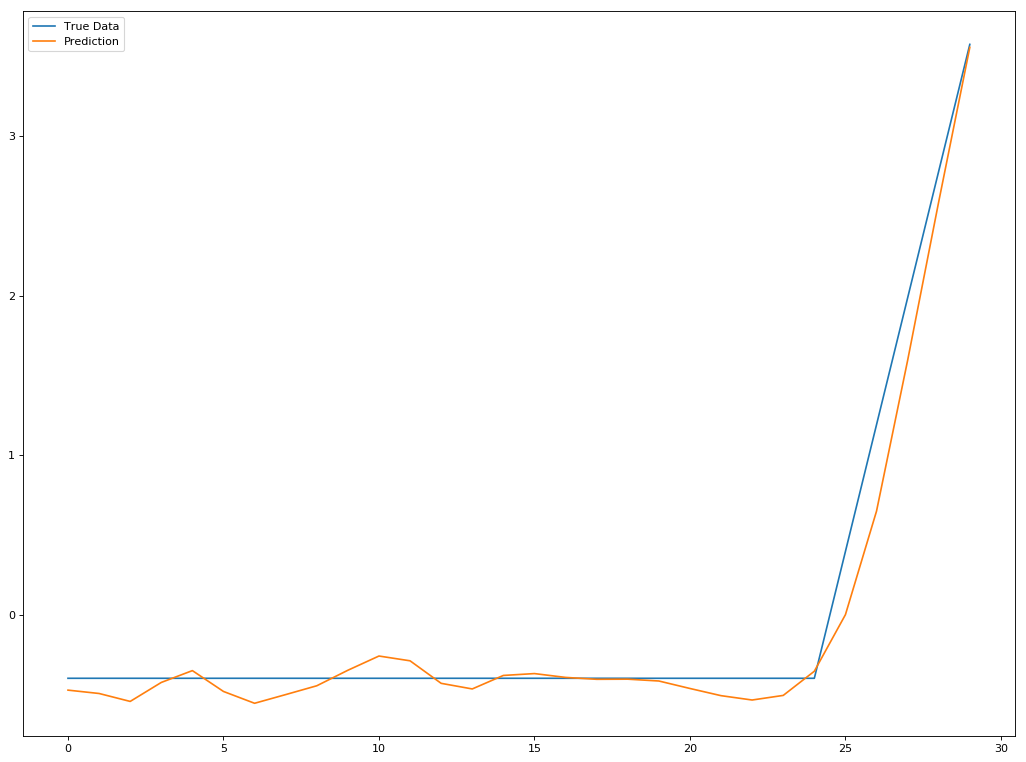

In [0]:
reconstructed_test_2 = autoencoder_model_2.predict(x_test_2)

for i in range(x_test_2.shape[2]):
  plot_results(reconstructed_test_2[0,:,i], x_test_2[0,:,i])

### Create Embeddings

In [0]:
x_train_2 = encoder_2.predict(x_train_2)
x_test_2 = encoder_2.predict(x_test_2)

### Save Models

In [0]:
autoencoder_model_2.save('bi_lstm_autoencoders_second_half.h5')
encoder_2.save('bi_lstm_encoder_second_half.h5')

### Create Prediction Model

In [0]:
model_2 = create_model(x_train_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_148 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 513       
Total params: 525,825
Trainable params: 525,825
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [0]:
callbacks_list = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
]

history = model_2.fit(x_train_2,
                      y_train_2,
                      batch_size=256,
                      epochs=5000,
                      shuffle=True,
                      callbacks=callbacks_list,
                      validation_split=0.1,
                      verbose=1)

model_2.save('bi_lstm_prediction_second_half.h5')

Train on 1644 samples, validate on 183 samples
Epoch 1/5000
1644/1644 [==============================] - 9s 6ms/sample - loss: 1.2791 - val_loss: 0.7742
Epoch 2/5000
1644/1644 [==============================] - 0s 33us/sample - loss: 0.5922 - val_loss: 0.6981
Epoch 3/5000
1644/1644 [==============================] - 0s 27us/sample - loss: 0.4153 - val_loss: 0.5799
Epoch 4/5000
1644/1644 [==============================] - 0s 25us/sample - loss: 0.3620 - val_loss: 0.5695
Epoch 5/5000
1644/1644 [==============================] - 0s 27us/sample - loss: 0.3145 - val_loss: 0.5441
Epoch 6/5000
1644/1644 [==============================] - 0s 28us/sample - loss: 0.2801 - val_loss: 0.5410
Epoch 7/5000
1644/1644 [==============================] - 0s 26us/sample - loss: 0.2581 - val_loss: 0.5259
Epoch 8/5000
1644/1644 [==============================] - 0s 26us/sample - loss: 0.2409 - val_loss: 0.5197
Epoch 9/5000
1644/1644 [==============================] - 0s 26us/sample - loss: 0.2281 - val_loss

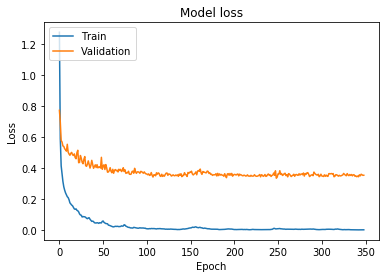

In [0]:
plot_loss(history)

### Predict for Test Set

In [0]:
predicted_2 = model_2.predict(x_test_2)

### Rescale Data

In [0]:
new_predicted_2 = []

for i in range(len(predicted_2)):
  temp = np.zeros((x_train_2.shape[2],))
  # 3 for closing price
  temp[3] = predicted_2[i]
  new_predicted_2.append(scalars_2[len(x_train_2)+i].inverse_transform(temp)[3])
  
predicted_2 = np.array(new_predicted_2)

### Plot Predictions

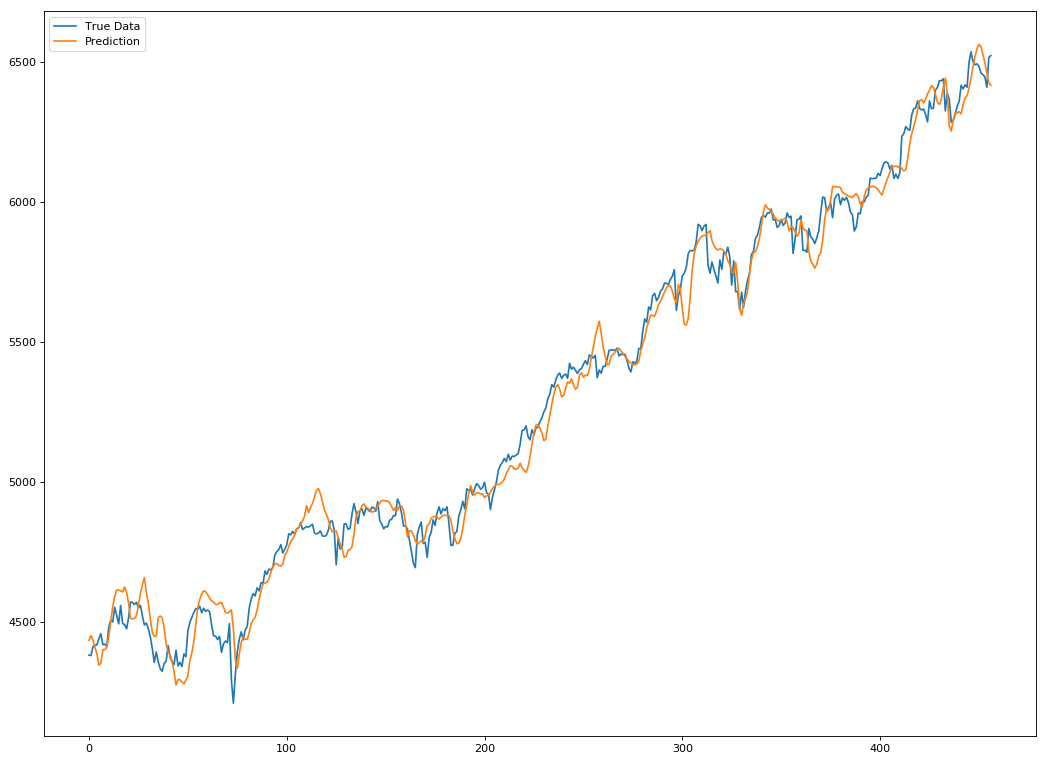

In [0]:
plot_results(predicted_2, original_data_2)

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted_2, original_data_2)

5102.67892549621

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data_2 - predicted_2) / original_data_2)) * 100)

1.0835040202304846


### Convert to Directional Data

In [0]:
predicted_directions_2 = directional_data(predicted_2, original_data_2)

No change: 111
Up: 165
Down: 180


In [0]:
actual_directions_2 = directional_data(original_data_2, original_data_2)

No change: 201
Up: 155
Down: 100


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions_2.argmax(axis=1)
predicted_classes_2 = classes[indices]

indices = actual_directions_2.argmax(axis=1)
y_true_2 = classes[indices]

By Count

Confusion matrix, without normalization
[[37 24 39]
 [87 45 69]
 [56 42 57]]


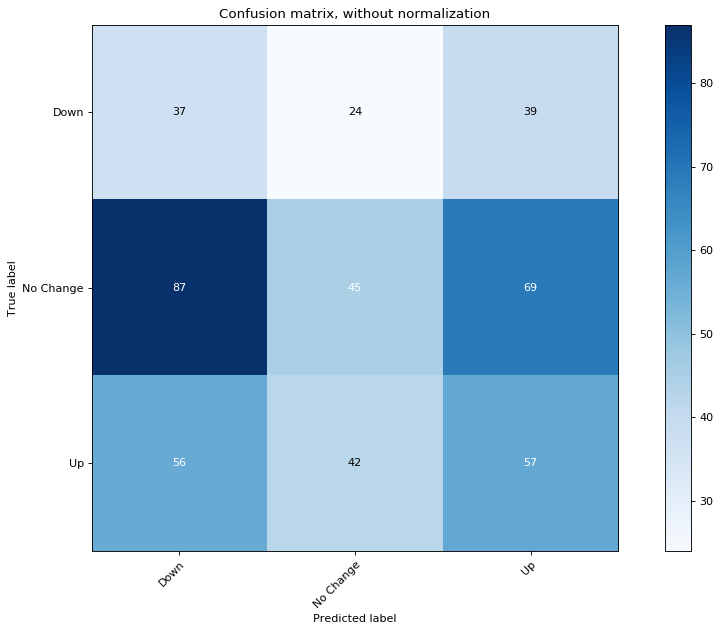

In [0]:
plot_confusion_matrix(y_true_2, predicted_classes_2, normalize=False)

Normalized

Normalized confusion matrix
[[0.37       0.24       0.39      ]
 [0.43283582 0.2238806  0.34328358]
 [0.36129032 0.27096774 0.36774194]]


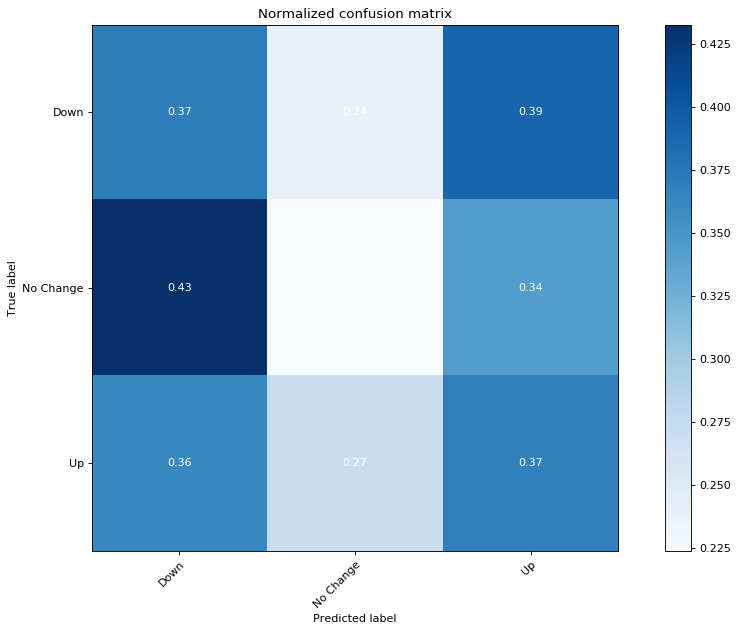

In [0]:
plot_confusion_matrix(y_true_2, predicted_classes_2, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true_2, predicted_classes_2)

0.3048245614035088

### Export to CSV

In [0]:
y_true_2 = np.insert(y_true_2, 0, 0)
predicted_classes_2 = np.insert(predicted_classes_2, 0, 0)

In [0]:
columns = ['Date', 'True Closing Values', 'Predicted Closing Values', 'True Values', 'Predicted Values']
data = np.array([dates_2, original_data_2, predicted_2, y_true_2, predicted_classes_2]).T

In [0]:
csv = pd.DataFrame(data, columns=columns)

csv.to_csv('bi_lstm_autoencoders_second_half.csv', index=False)

## Download Files

In [0]:
from google.colab import files

files.download('bi_lstm_autoencoders_second_half.csv')

files.download('bi_lstm_autoencoders_second_half.h5')

files.download('bi_lstm_encoder_second_half.h5')

files.download('bi_lstm_prediction_second_half.h5')

## Results

In [0]:
predicted_all = np.concatenate((predicted, predicted_2))

original_data_all = np.concatenate((original_data, original_data_2))

predicted_directions_all = np.concatenate((predicted_directions, predicted_directions_2))

actual_directions_all = np.concatenate((actual_directions, actual_directions_2))

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted_all, original_data_all)

3831.1795193113508

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data_all - predicted_all) / original_data_all)) * 100)

1.611110384782979


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions_all.argmax(axis=1)
predicted_classes_all = classes[indices]

indices = actual_directions_all.argmax(axis=1)
y_true_all = classes[indices]

By Count

Confusion matrix, without normalization
[[118  50 108]
 [144  52 100]
 [129  67 144]]


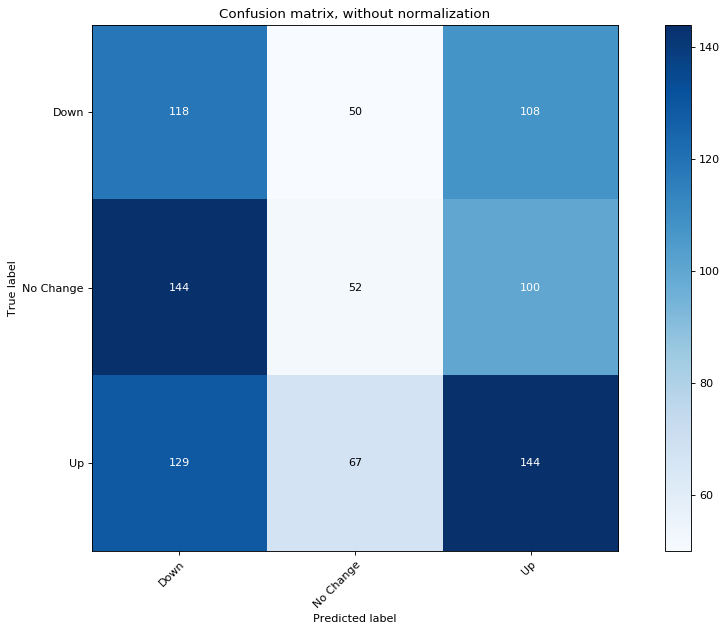

In [0]:
plot_confusion_matrix(y_true_all, predicted_classes_all, normalize=False)

Normalized

Normalized confusion matrix
[[0.42753623 0.18115942 0.39130435]
 [0.48648649 0.17567568 0.33783784]
 [0.37941176 0.19705882 0.42352941]]


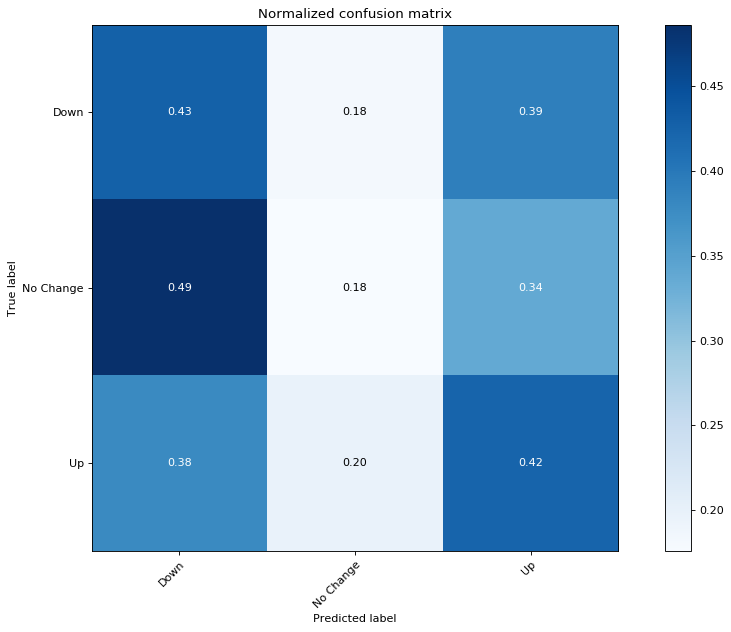

In [0]:
plot_confusion_matrix(y_true_all, predicted_classes_all, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true_all, predicted_classes_all)

0.3442982456140351